# Effects of dropout on propagation speed of synfire chains and their recurrent variants

The aim of this notebook is to investigate how physical perturbations to HVC might affect its dynamics.

## Network Architecture
Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.

### Chain structure and connectivity

The 'modified' synfire chain is constructed as follows: we first define a chainlink as a collection of neurons with random, recurrent, excitatory connections. The number of afferents each neuron receives is normalized (specifically, we specify the percentage of the total number of neurons within the chainlink from which each neuron receives afferents).

Chainlinks are then ordered, and each neuron in chainlink i+1 receives excitatory connections from each neuron
in chainlink i.

# Code
### Define reversal potentials, conductance decay timescales, network properties, and other constants

In [50]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    V_TH_NACH =-.055, # modified spike threshold (V) for NaChBac-mutant cells
    T_R_E=2e-3,  # refractory period (s)
    T_R_NACH=1, # refractory period for NaChBac-mutant cells
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_P_I =300, # num nrns in inhibitory pool
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E=0.01,
    W_U_I=0.8e-3,
    W_A=0, # adaptation weight for all neurons
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

def set_dynamic_vars(m):
    m.N_E = m.N_L * m.N_L_E
    m.N_N = m.N_E + m.N_P_I

set_dynamic_vars(M)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


# Single neuron EPSPs and IPSPs

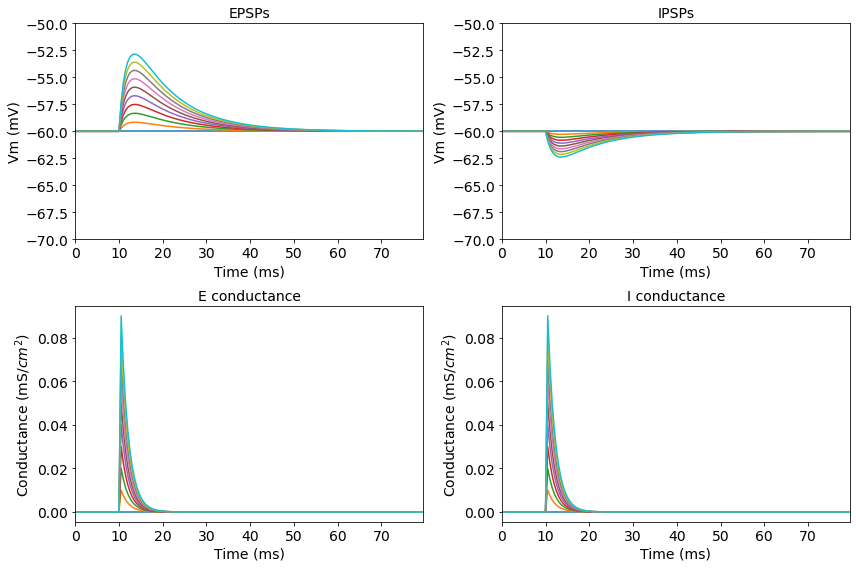

In [51]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .08, S.DT)
rsps_e = []

for w_u_e_e in np.arange(10) * 0.01e-3:
    w_u_e_i = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_L_E,
        t_r=np.inf,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_I},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)), 0] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_e.append(copy(rsp))
    

# IPSP size vs I weight
rsps_i = []

for w_u_e_i in np.arange(10) * 0.01e-3:
    w_u_e_e = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_L_E,
        t_r=np.inf,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_E},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)), 1] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_i.append(copy(rsp))

    
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
for rsp_e in rsps_e:
    axs[0, 0].plot(1000*t, 1000*rsp_e.vs[:, 0])
    axs[1, 0].plot(1000*t, 1000*rsp_e.gs['E'][:, 0])
for rsp_i in rsps_i:
    axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0])
    axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0])
    
for ax in axs[0, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_ylim(-70, -50)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    
for ax in axs[1, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Conductance (mS/$cm^2$)')
    
axs[0, 0].set_title('EPSPs')
axs[0, 1].set_title('IPSPs')

axs[1, 0].set_title('E conductance')
axs[1, 1].set_title('I conductance')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

# Full chain

### Helper functions for defining network connectivity

In [52]:
def dropout_on_mat(mat, percent):
    dropout_indices = rand_bin_array_with_percentage_ones(mat.shape[1], int((1 - percent) * mat.shape[1]))
    m = copy(mat)
    for idx, val in enumerate(dropout_indices):
        m[:, idx] = val * m[:, idx]
    return m

def rand_replace_val(mat, percent, val):
    repl_indices = rand_bin_array_with_percentage_ones(mat.shape[0], int(percent * mat.shape[0]))
    mat_copy = copy(mat)
    mat_copy[repl_indices.nonzero()[0]] = val
    return mat_copy, repl_indices

def replace_val_at_indices(mat, val, repl_indices):
    mat_copy = copy(mat)
    mat_copy[repl_indices.nonzero()[0]] = val
    return mat_copy

## E-E weights
def make_w_r_e(m, weights, cnxn_probs):
    w_r_e = np.zeros([m.N_N]*2)

    # btwn links
    w_r_e_e = np.zeros([m.N_E]*2)
    for l_idx in range(1, m.N_L):
        row_idx = l_idx * m.N_L_E
        col_idx = (l_idx - 1) * m.N_L_E
        ff_connectivity = weights['e_e_f'] * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), cnxn_probs['e_e_f'])
        w_r_e_e[row_idx:(row_idx + m.N_L_E), col_idx:(col_idx + m.N_L_E)] = ff_connectivity
    
    # intrachainlink recurrent connections are sparsified so that each neuron receives connections from 
    # 'percent_cnxn_e_e' * N_L_E neurons
    for i in range(m.N_L):
        w_r_e_e[(i * m.N_L_E):((i+1) * m.N_L_E), (i * m.N_L_E):((i+1) * m.N_L_E)] = \
            weights['e_e_r'] * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), cnxn_probs['e_e_r'])

    w_r_e[:m.N_E, :m.N_E] = w_r_e_e
    # connections to inhibitory neurons are also sparsified, but for this set of experiments, the weights are set to zero
    w_r_e[m.N_E:, :m.N_E] = weights['e_i'] * sprs_mat_with_rand_percent_cnxns((m.N_E, m.N_P_I), cnxn_probs['e_i'])
    
    return w_r_e

# define recurrent inhibitory connections
def make_w_r_i(m, weights, cnxn_probs):
    w_r_i = np.zeros((m.N_N, m.N_N))
    w_r_i[:m.N_E, m.N_E:] = weights['i_e'] * sprs_mat_with_rand_percent_cnxns((m.N_P_I, m.N_E), cnxn_probs['i_e'])
    return w_r_i

# define structure of external inhibitory input
def make_w_u_i(m, weights):
    w_u_i = np.zeros([m.N_N, m.N_N + m.N_L_E])
    w_u_i[(-m.N_P_I):, (-m.N_P_I):] = weights['u_i'] * np.eye(m.N_P_I)
    return w_u_i

In [53]:
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

def bin_occurrences(occurrences, min_idx=0, max_idx=None, bin_size=1):
    if max_idx is None:
        max_idx = occurrences.max() + 1
    binned = np.zeros(max_idx - min_idx)
    for n in occurrences:
        if n >= max_idx or n < min_idx:
            raise IndexError(f'index {n} is out of bounds for min {min_idx} and max {max_idx}')
        binned[n - min_idx] += 1
    return binned

In [54]:
def calc_degree_dist(mat):
    degree_freqs = bin_occurrences(np.count_nonzero(mat, axis=1))
    return np.arange(len(degree_freqs)), degree_freqs

def gen_degree_dist_graphs(w_r, m):
    w_r_e_e = w_r['E'][:m.N_E, :m.N_E]
    w_r_e_i = w_r['E'][m.N_E:, :m.N_E]
    w_r_i_e = w_r['I'][:m.N_E, m.N_E:]
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
    
    w_r_e_e_degs, w_r_e_e_deg_freqs = calc_degree_dist(w_r_e_e)
    axs[0, 0].bar(w_r_e_e_degs, w_r_e_e_deg_freqs)
    axs[0, 0].set_title('E afferents for HVC(RA)')
    axs[0, 0].set_ylim(0, w_r_e_e_deg_freqs.max())
    
    w_r_e_i_degs, w_r_e_i_deg_freqs = calc_degree_dist(w_r_e_i)
    axs[0, 1].bar(w_r_e_i_degs, w_r_e_i_deg_freqs)
    axs[0, 1].set_title('E afferents for interneuron')
    axs[0, 1].set_ylim(0, w_r_e_i_deg_freqs.max())
    
    w_r_i_e_degs, w_r_i_e_deg_freqs = calc_degree_dist(w_r_i_e)
    axs[1, 0].bar(w_r_i_e_degs, w_r_i_e_deg_freqs)
    axs[1, 0].set_title('I afferents for HVC(RA)')
    axs[1, 0].set_ylim(0, w_r_i_e_deg_freqs.max())
    
def show_afferent_stats(w_r, m_t):
    link_indices = np.arange(m_t.N_L)
    num_exc_afferents = np.zeros((m_t.N_L - 1, m_t.N_L_E))
    num_projs_to_inh = np.zeros((m_t.N_L - 1, m_t.N_P_I))
            
    for l_idx in link_indices:
        if l_idx == 0:
            continue
        num_exc_afferents[l_idx - 1, :] = np.count_nonzero(w_r['E'][l_idx * m_t.N_L_E : (l_idx + 1) * m_t.N_L_E, :], axis=1)
        num_projs_to_inh[l_idx - 1, :] = np.count_nonzero(w_r['E'][m_t.N_E:, l_idx * m_t.N_L_E : (l_idx + 1) * m_t.N_L_E], axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
    
    mean_exc_afferents = np.mean(num_exc_afferents, axis=1)
    std_exc_afferents = np.std(num_exc_afferents, axis=1)
    
    mean_projs_to_inh = np.mean(num_projs_to_inh, axis=1)
    std_projs_to_inh = np.std(num_projs_to_inh, axis=1)
    
    axs[0].fill_between(link_indices[1:], mean_exc_afferents - std_exc_afferents, mean_exc_afferents + std_exc_afferents, alpha=0.3)
    axs[0].plot(link_indices[1:], mean_exc_afferents)
    axs[0].set_ylim(0, 50)
    axs[1].fill_between(link_indices[1:], mean_projs_to_inh - std_projs_to_inh, mean_projs_to_inh + std_projs_to_inh, alpha=0.3)
    axs[1].plot(link_indices[1:], np.mean(num_projs_to_inh, axis=1))
    axs[1].set_ylim(0, 30)

### Define function for simulating a single set of parameters using three different input UVA frequences

In [55]:
'''
    Parameters:
        0. Generic class with hyperparams
        1. excitatory -> inhibitory weight (0 for this experiment)
        2. inhibitory -> excitatory weight (0 for this experiment)
        3. excitatory -> excitatory recursive (within chainlink) weight
        4. excitatory -> excitatory feed-forward (chainlink -> chainlink) weight
        5. weight of external inhibition (0 for this experiment)
        6. fraction of total nuerons in excitatory chainlink that a single excitatory cell receieves afferents from
        7. fraction of total nuerons in entire chain that a single inhibitory cell receieves afferents from
        8. fraction of total neurons in prior chainlink that neuron in current chainlink receives afferents from
'''

def run_test(m_t, weights, cnxn_probs,
             show_connectivity=False, repeats=1, dropouts=[{'e': 0, 'i': 0}], n_show_only=None, add_noise=True):
    
    t_r_base = np.ones(m_t.N_N) * m_t.T_R_E
    v_th_base = np.ones(m_t.N_N) * m_t.V_TH_E
    
    t_r_for_dropouts = []
    v_th_for_dropouts = []
    
    for dropout in dropouts:
        t_r = copy(t_r_base)
        t_r[:m_t.N_E], exc_repl_indices = rand_replace_val(t_r[:m_t.N_E], dropout['e'], m_t.T_R_NACH)
        t_r[m_t.N_E:], inh_repl_indices = rand_replace_val(t_r[m_t.N_E:], dropout['i'], m_t.T_R_NACH)
        t_r_for_dropouts.append(t_r)
        
        v_th = copy(v_th_base)
        v_th[:m_t.N_E] = replace_val_at_indices(v_th[:m_t.N_E], m_t.V_TH_NACH, exc_repl_indices)
        v_th[m_t.N_E:] = replace_val_at_indices(v_th[m_t.N_E:], m_t.V_TH_NACH, inh_repl_indices)
        v_th_for_dropouts.append(v_th)

    ## input weights
    w_u_base = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ m_t.W_U_E * np.eye(m_t.N_L_E), np.zeros([m_t.N_L_E, m_t.N_N]) ],
            [ np.zeros([m_t.N_N - m_t.N_L_E, m_t.N_N + m_t.N_L_E]) ],
        ]),

        # global inhibitory inputs across chain
        'I': make_w_u_i(m_t, weights)
    }
    
    ## recurrent weights
    w_r_base = {
        'E': make_w_r_e(m_t, weights, cnxn_probs),
        'I': make_w_r_i(m_t, weights, cnxn_probs),
        'A': m_t.W_A * np.eye(m_t.N_N),
    }
    
    # generate timesteps and initial excitatory input window
    t = np.arange(0, S.T, S.DT)
    
    t_u_1 = [.01, .013]
    t_mask_1 = (t_u_1[0] <= t) & (t < t_u_1[1])
    t_u_2 = [.31, .313]
    t_mask_2 = (t_u_2[0] <= t) & (t < t_u_2[1])
    
    FQ_SPK_U_I = [0]
    all_rsps = []
    
    w_u = copy(w_u_base)
    w_r = copy(w_r_base)

    # run simulation for same set of parameters
    for rp_idx in range(repeats):
        show_trial = (type(n_show_only) is int and rp_idx < n_show_only)

        rsps_for_trial = []

        ## external currents
        if add_noise:
            i_ext = m_t.SGM_N/S.DT * np.random.randn(len(t), m_t.N_N) + m_t.I_EXT_B
        else:
            i_ext = m_t.I_EXT_B * np.ones((len(t), m_t.N_N))

        ## inp spks
        spks_u_base = np.zeros((len(t), m_t.N_L_E + m_t.N_N), dtype=int)

        # trigger inputs
        tmp_1 = cc([np.ones(m_t.N_L_E, int), np.zeros(m_t.N_L_E*(t_mask_1.sum()-1))])
        spks_u_base[t_mask_1, :m_t.N_L_E] = tmp_1[np.random.permutation(len(tmp_1))].reshape(t_mask_1.sum(), m_t.N_L_E)
        tmp_2 = cc([np.ones(m_t.N_L_E, int), np.zeros(m_t.N_L_E*(t_mask_2.sum()-1))])
        spks_u_base[t_mask_2, :m_t.N_L_E] = tmp_2[np.random.permutation(len(tmp_2))].reshape(t_mask_2.sum(), m_t.N_L_E)

        for d_idx, dropout in enumerate(dropouts):
            rsps_for_dropout = []
            t_r_for_dropout = t_r_for_dropouts[d_idx]
            v_th_for_dropout = v_th_for_dropouts[d_idx]
            
            if show_trial:
                # gen_degree_dist_graphs(w_r, m_t)
                show_afferent_stats(w_r, m_t)
            
            if show_connectivity:
                fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
                axs[0, 0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
                axs[0, 0].set_title('W_R[E]\n')
                axs[0, 1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
                axs[0, 1].set_title('W_R[I]\n')

                axs[1, 0].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
                axs[1, 0].set_title('W_U[E]\n')
                axs[1, 1].spy(w_u['I'], markersize=1)
                axs[1, 1].set_title('W_U[I]\n')

                for ax in axs.flatten():
                    set_font_size(ax, 14)

            for fq_idx, fq_spk_u_i in enumerate(FQ_SPK_U_I):

                ntwk = LIFNtwkG(
                    c_m=m_t.C_M_E,
                    g_l=m_t.G_L_E,
                    e_l=m_t.E_L_E,
                    v_th=v_th_for_dropout,
                    v_r=m_t.E_L_E,
                    t_r=t_r_for_dropout,
                    e_s={'E': M.E_E, 'I': M.E_I, 'A': M.E_A},
                    t_s={'E': M.T_E, 'I': M.T_E, 'A': M.T_A},
                    w_r=w_r,
                    w_u=w_u)

                clamp = Generic(
                    v={0: np.repeat(m_t.E_L_E, m_t.N_N)}, spk={})

                spks_u = spks_u_base.copy()
    #             spks_u[:, -(m_t.N_P_I):] = np.random.poisson(fq_spk_u_i * S.DT, (len(t), m_t.N_P_I))

                # run smln
                rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

                rsps_for_dropout.append({
                    'spks_t': copy(rsp.spks_t),
                    'spks_c': copy(rsp.spks_c),
                    'spks_u': spks_u_base.nonzero(),
                })

            rsps_for_trial.append(rsps_for_dropout)
        all_rsps.append(rsps_for_trial)
    return all_rsps

In [56]:
def quick_plot(m, weights, cnxn_probs, dropouts,
               overlay=False, repeats=1, show_connectivity=True, n_show_only=None, add_noise=True):
    all_rsps = run_test(m, weights, cnxn_probs,
                        dropouts=dropouts, show_connectivity=show_connectivity, repeats=repeats, n_show_only=n_show_only,
                        add_noise=add_noise)
    
    mean_spks_dataframe = pd.DataFrame({
        'trial': [],
        'dropout_idx': [],
        'mean_spk_times': [],
    })
    
    for idx_r, rsps in enumerate(all_rsps):
        for idx_do, rsps_for_dropout in enumerate(rsps):
            show_trial = (type(n_show_only) is int and idx_r < n_show_only)

            if overlay and show_trial:
                gs = gridspec.GridSpec(5, 1)
                fig = plt.figure(figsize=(10, 20), tight_layout=True)
                axs = [fig.add_subplot(gs[0:2]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3]), fig.add_subplot(gs[4])]

            colors = ['red', 'blue', 'green']
            inv_slopes = []

            mean_spk_times_per_link = [] 

            for frq_idx, frq_res in enumerate(rsps_for_dropout):
                tms_p_link = tms_for_link(frq_res['spks_t'], frq_res['spks_c'], m.N_L, m.N_L_E)
                mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
                x = np.arange(m.N_L) + 1
                slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]

                inv_slope = 1./slp
                inv_slopes.append(inv_slope)
                
                raster = np.stack([frq_res['spks_t'], frq_res['spks_c']])
                inh_raster = raster[:, raster[1, :] >= m.N_E]
                exc_raster = raster[:, raster[1, :] < m.N_E]
                
                mean_spk_times = np.zeros(m.N_L)
                mean_spk_cnts = np.zeros(m.N_L)
                std_spk_cnts = np.zeros(m.N_L)
                
                for l_cntr in range(m.N_L):
                    link_window = (exc_raster[1, :] >= l_cntr * m.N_L_E) & (exc_raster[1, :] < ((l_cntr + 1) * m.N_L_E))
                    link_spks = exc_raster[:, link_window]
                    
                    if show_trial:
                        if overlay:
                            c = colors[frq_idx]
                        else:
                            c = 'black' if l_cntr % 2 == 0 else 'grey'
                        axs[0].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
                        axs[2].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
                        # axs[0].plot(link_spks[0, :] * 1000, m.N_L_E * (link_spks[0, :] - icpt) * inv_slope, c='black')

                    mean_spk_times[l_cntr] = link_spks[0, :].mean()
                    spk_cnts_per_nrn = bin_occurrences(link_spks[1, :].astype(int) - l_cntr * m.N_L_E, max_idx=m.N_L_E)
                    mean_spk_cnts[l_cntr] = spk_cnts_per_nrn.mean()
                    std_spk_cnts[l_cntr] = spk_cnts_per_nrn.std()
                
                mean_spks_dataframe = mean_spks_dataframe.append(pd.DataFrame({
                    'trial': [idx_r],
                    'dropout_idx': [idx_do],
                    'mean_spk_times': [mean_spk_times],
                }))

                if show_trial:
                    if not overlay:
                        gs = gridspec.GridSpec(4, 1)
                        fig = plt.figure(figsize=(10, 16), tight_layout=True)
                        axs = [fig.add_subplot(gs[0:2]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3:])]

                    axs_1_color = 'red' if not overlay else colors[frq_idx]

                    axs[1].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - m.N_E + frq_idx * m.N_P_I,
                                   s=1, c=axs_1_color, zorder=0, alpha=.8)
                    axs[1].set_ylabel('Inh Cell Index')
                    axs[1].set_xlabel('Time (ms)')
                    axs[1].set_ylim(-1, len(rsps_for_dropout) * m.N_P_I)

                    for i in range(3):
                        axs[i].set_xlim(0, S.T * 1000)

                    axs[0].set_title(f'Inhibition: {int(frq_idx * 400)} Hz')
                    axs[0].set_ylim(-1, m.N_E)
                    axs[0].set_ylabel('Exc Cell Index')
                    axs[0].set_xlabel('Time (ms)')
                    axs[2].set_ylim(0, 300)
                    axs[2].set_ylabel('Exc Cell Index')
                    axs[2].set_xlabel('Time (ms)')
                    axs[3].set_xlabel('Link #')
                    axs[3].set_ylabel('Avg Number of Spikes / Neuron')
                    axs[3].set_xlim(0, m.N_L)
                    
                    link_indices = np.arange(len(mean_spk_cnts))

                    axs[3].fill_between(link_indices, mean_spk_cnts - std_spk_cnts, mean_spk_cnts + std_spk_cnts, color=c, alpha=0.3)
                    axs[3].scatter(link_indices, mean_spk_cnts, s=1, c=c)
    
    mean_spks_dataframe = mean_spks_dataframe.astype({'trial': 'int32', 'dropout_idx': 'int32'})
                    
    return mean_spks_dataframe

In [57]:
S.T = 0.5
m = copy(M)
m.N_L_E = 30
m.N_L = 75
set_dynamic_vars(m)

'''
    Parameters:
        0. Generic class with hyperparams
        1. excitatory -> inhibitory weight (0 for this experiment)
        2. inhibitory -> excitatory weight (0 for this experiment)
        3. excitatory -> excitatory recursive (within chainlink) weight
        4. excitatory -> excitatory feed-forward (chainlink -> chainlink) weight
        5. weight of external inhibition (0 for this experiment)
        6. fraction of total nuerons in excitatory chainlink that a single excitatory cell receieves afferents from
        7. fraction of total nuerons in entire chain that a single inhibitory cell receieves afferents from
        8. fraction of total neurons in prior chainlink that neuron in current chainlink receives afferents from
'''
None

In [58]:
def graph_dropout_sim_results(res,
                              labels=['0% dropout', '10% dropout', '15% dropout', '20% dropout', '30% dropout']):
    gs = gridspec.GridSpec(4, 1)
    fig = plt.figure(figsize=(10, 20), tight_layout=True)
    axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3])]

    colors = ['black', 'blue', 'red', 'green', 'orange']
    
    dropouts = np.sort(to_unique_vals(res, 'dropout_idx')[0])

    for idx_do in dropouts:

        link_indices = np.arange(m.N_L)
        c = colors[idx_do]
        label = labels[idx_do]
        
        data_for_dropout = select(res, {'dropout_idx': idx_do})
        
        idx = 0
        for idx_r, row in data_for_dropout.iterrows():
            if idx == 0:
                axs[0].plot(row['mean_spk_times'] * 1000, link_indices, c=c, label=label, lw=0.5)
            else:
                axs[0].plot(row['mean_spk_times'] * 1000, link_indices, c=c, lw=0.5)
            
            mean_time_diff = row['mean_spk_times'] * 1000 - shift(row['mean_spk_times'] * 1000, 1, cval=0)
            
            axs[3].plot(row['mean_spk_times'] * 1000, mean_time_diff, c=c, lw=0.3)
            
            idx += 1
            
        mean_spk_tms_for_do = data_for_dropout['mean_spk_times']
        mean_spk_tms_for_do = np.stack(mean_spk_tms_for_do, axis=1)

        mean_of_mean_spk_tms = np.nanmean(mean_spk_tms_for_do, axis=1)
        std_of_mean_spk_tms = np.nanstd(mean_spk_tms_for_do, axis=1)
        count_non_nan = np.count_nonzero(~np.isnan(mean_spk_tms_for_do), axis=1)
        std_err_of_mean_spk_tms = std_of_mean_spk_tms / np.sqrt(count_non_nan)

        axs[1].fill_betweenx(link_indices,
                            (mean_of_mean_spk_tms - std_err_of_mean_spk_tms) * 1000,
                            (mean_of_mean_spk_tms + std_err_of_mean_spk_tms) * 1000,
                            color=c, alpha=0.3, zorder=0)
        axs[1].plot(mean_of_mean_spk_tms * 1000, link_indices, c=c, zorder=1)
        
        axs[2].plot(mean_of_mean_spk_tms * 1000, std_err_of_mean_spk_tms * 1000, c=c)

    axs[0].legend()
    for i_ax, ax in enumerate(axs[:2]):
        ax.set_ylabel('Link Number')
        ax.set_xlabel('Mean Spike Time (ms)')
        
    axs[2].set_ylabel('Std Err of Mean Spike Time (ms)')
    axs[2].set_xlabel('Mean Spike Time (ms)')
    
    axs[3].set_ylim(0, 4)
    

## Pure synfire chain with noise and varying degrees of dropout
- We specify 4 different percentages of excitatory neurons to dropout and create 5 instances of each.
- We then simulate each instance with 20 pairs of unique initial excitation and realization of the white noise in the current

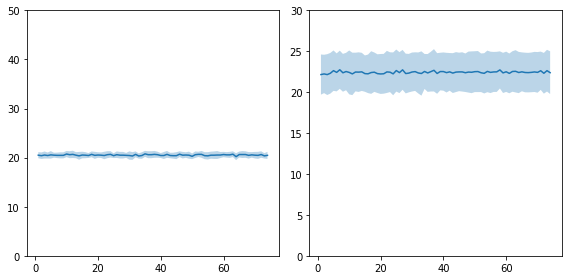

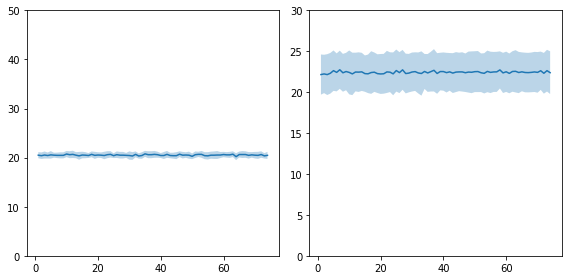

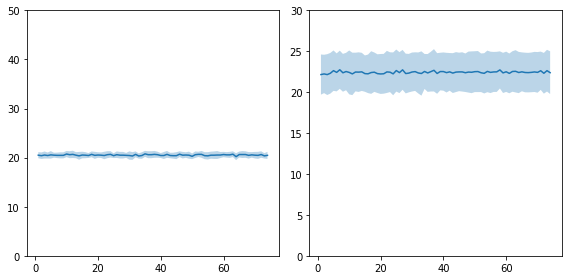

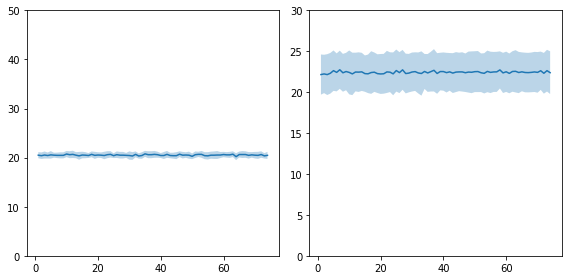

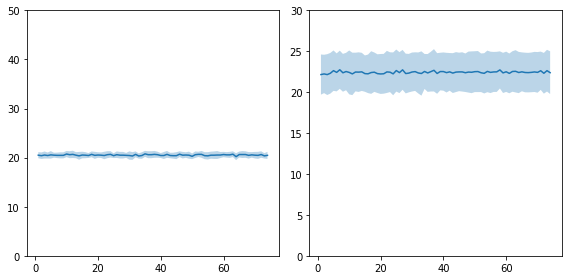

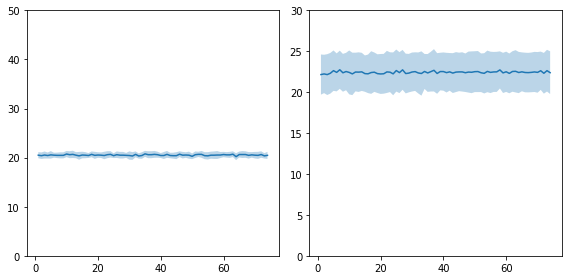

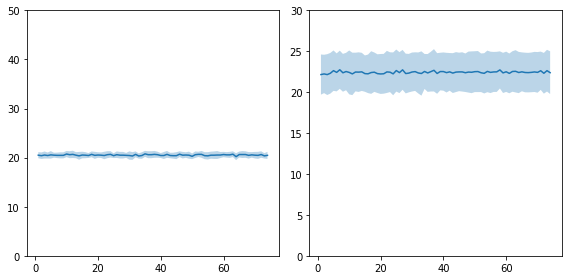

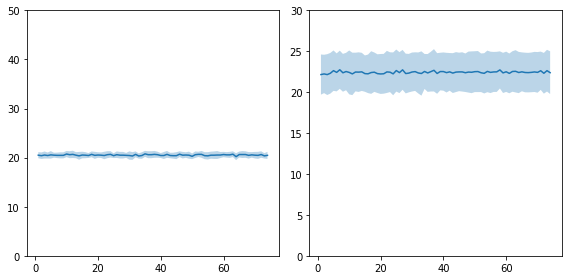

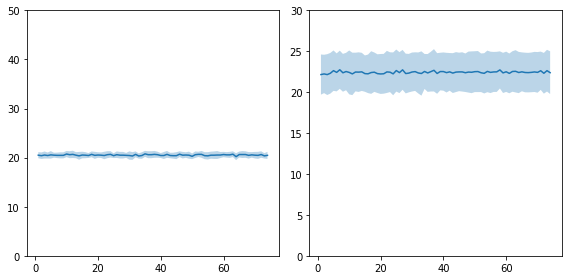

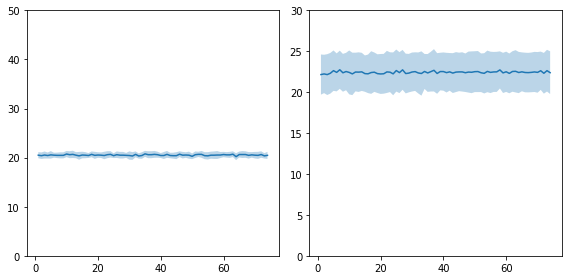

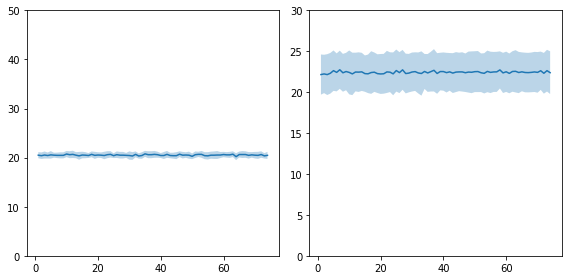

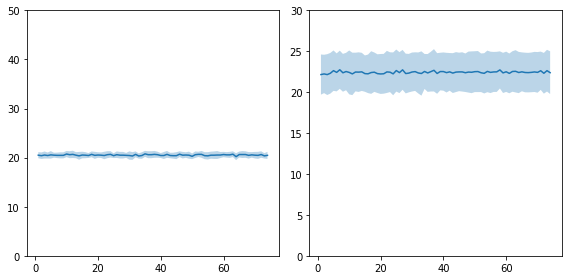

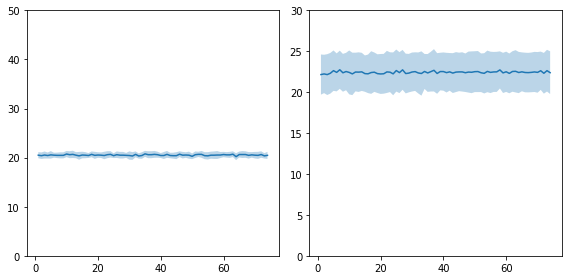

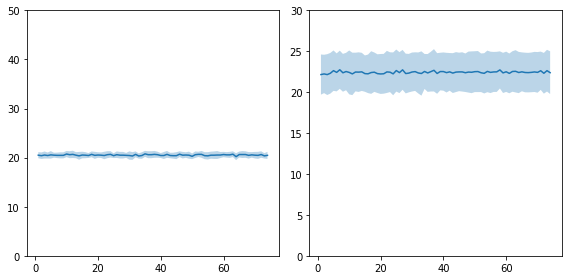

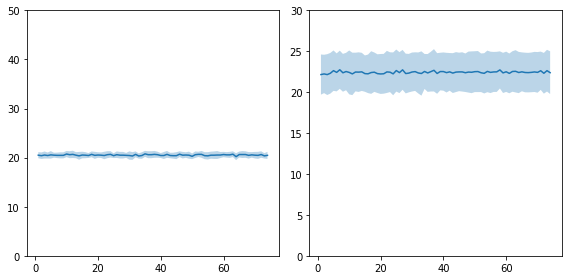

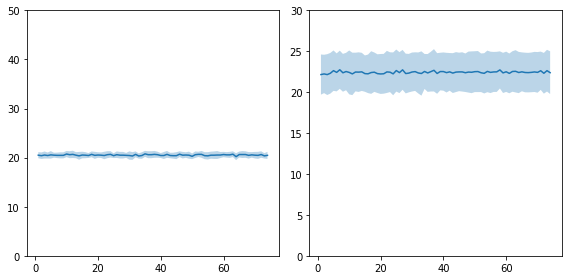

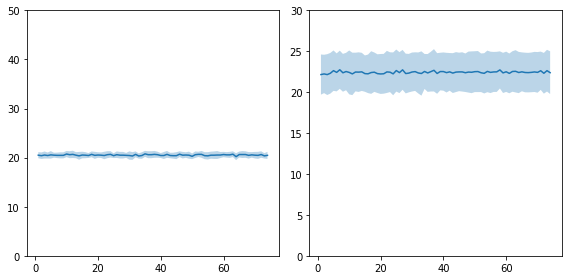

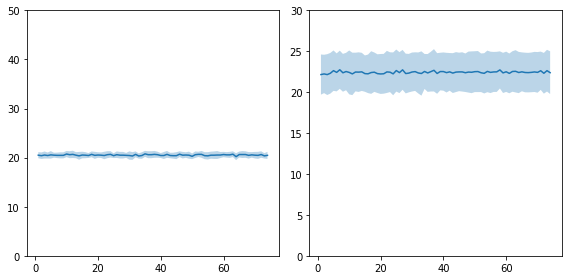

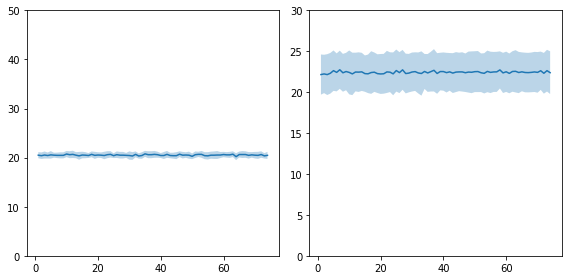

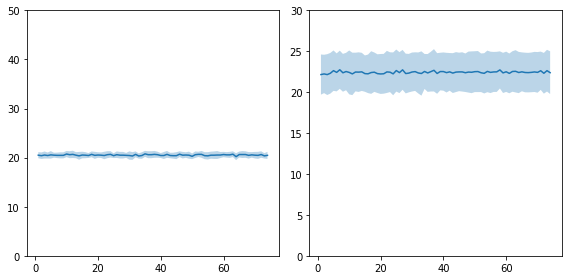

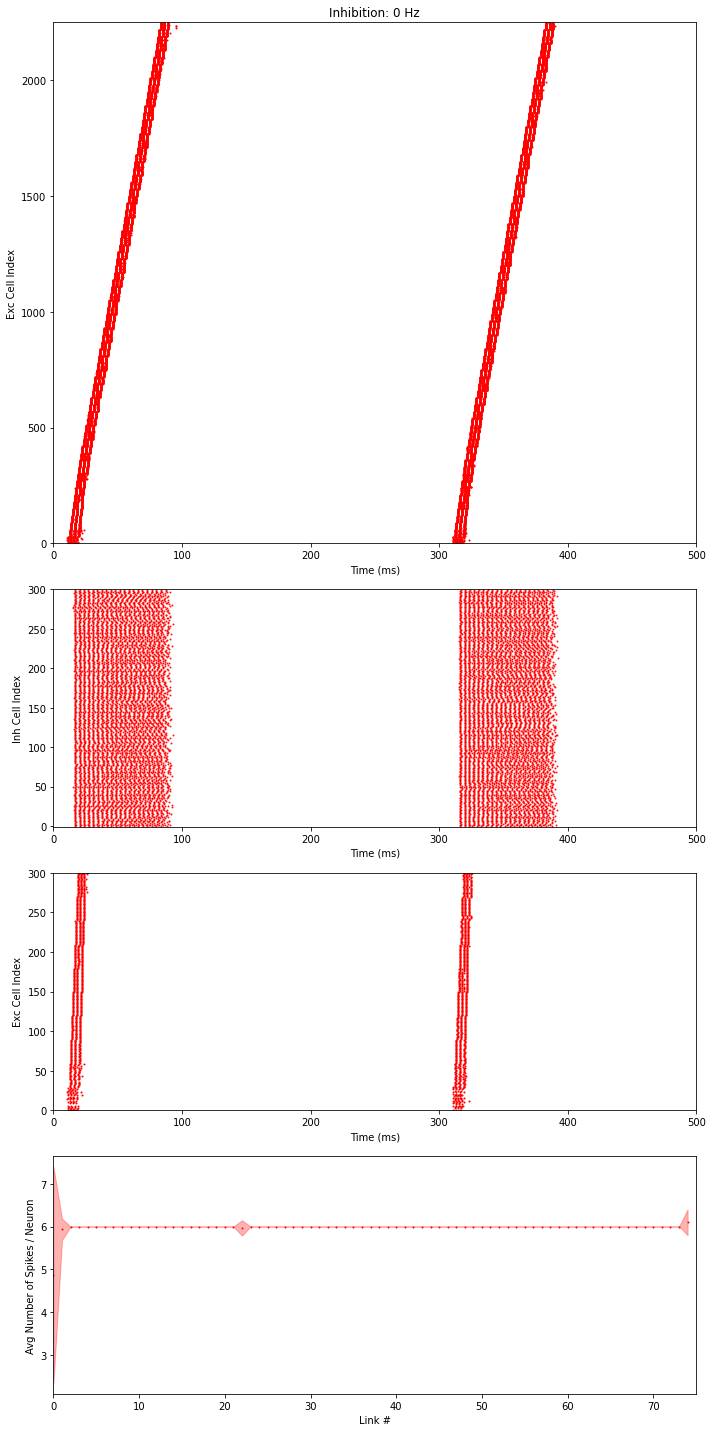

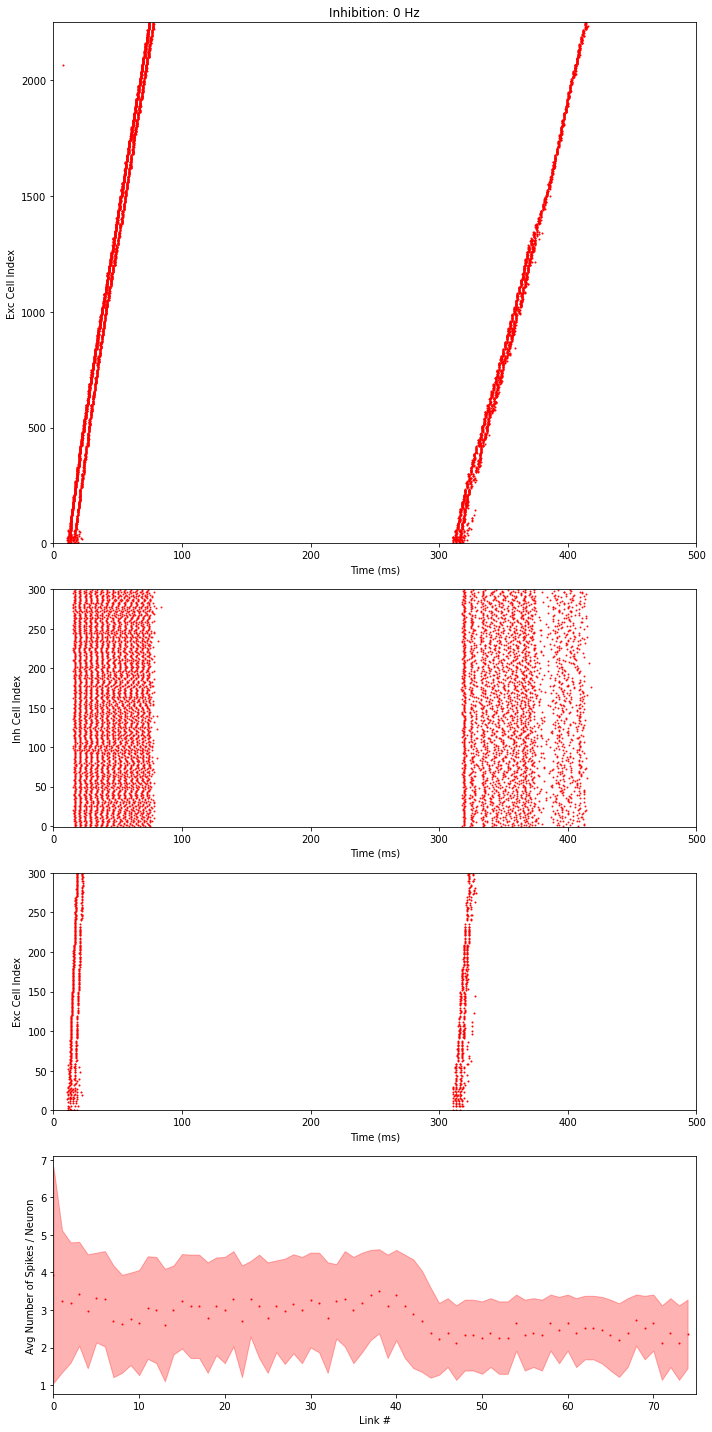

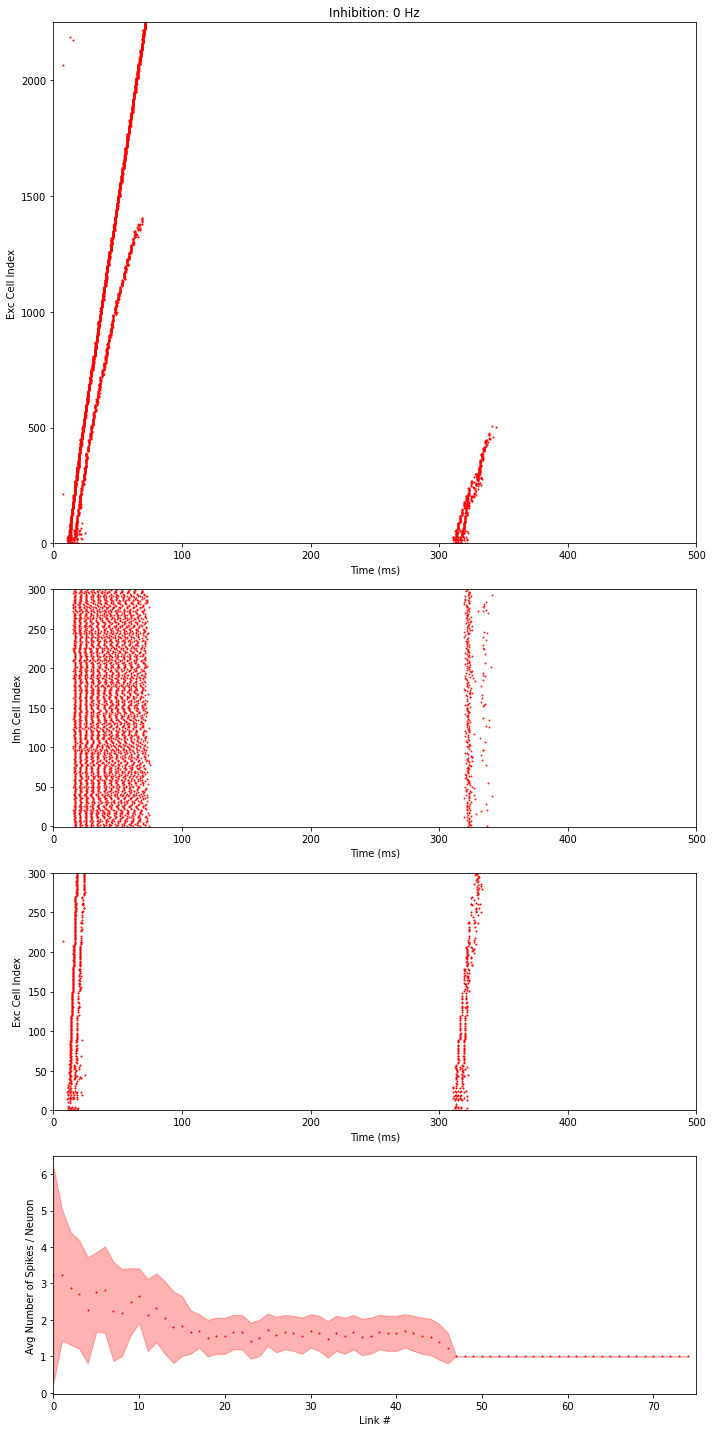

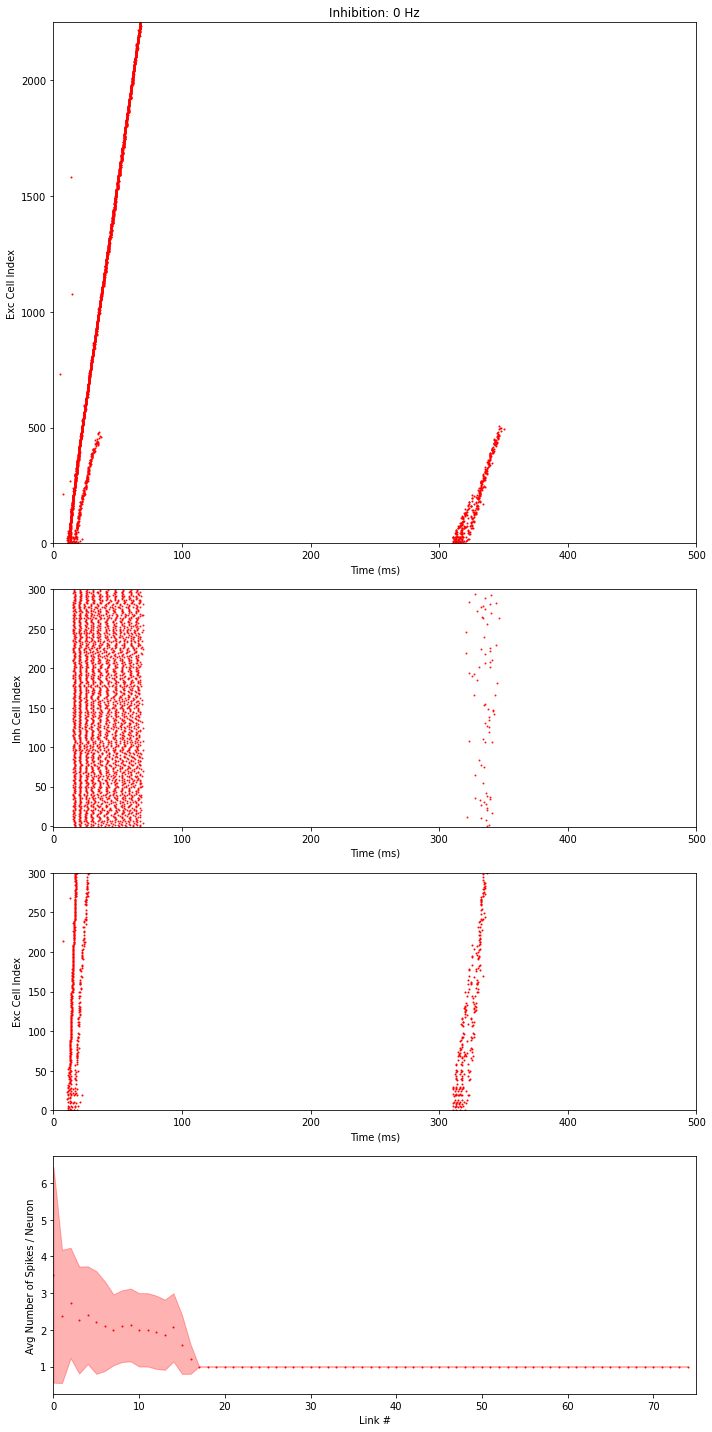

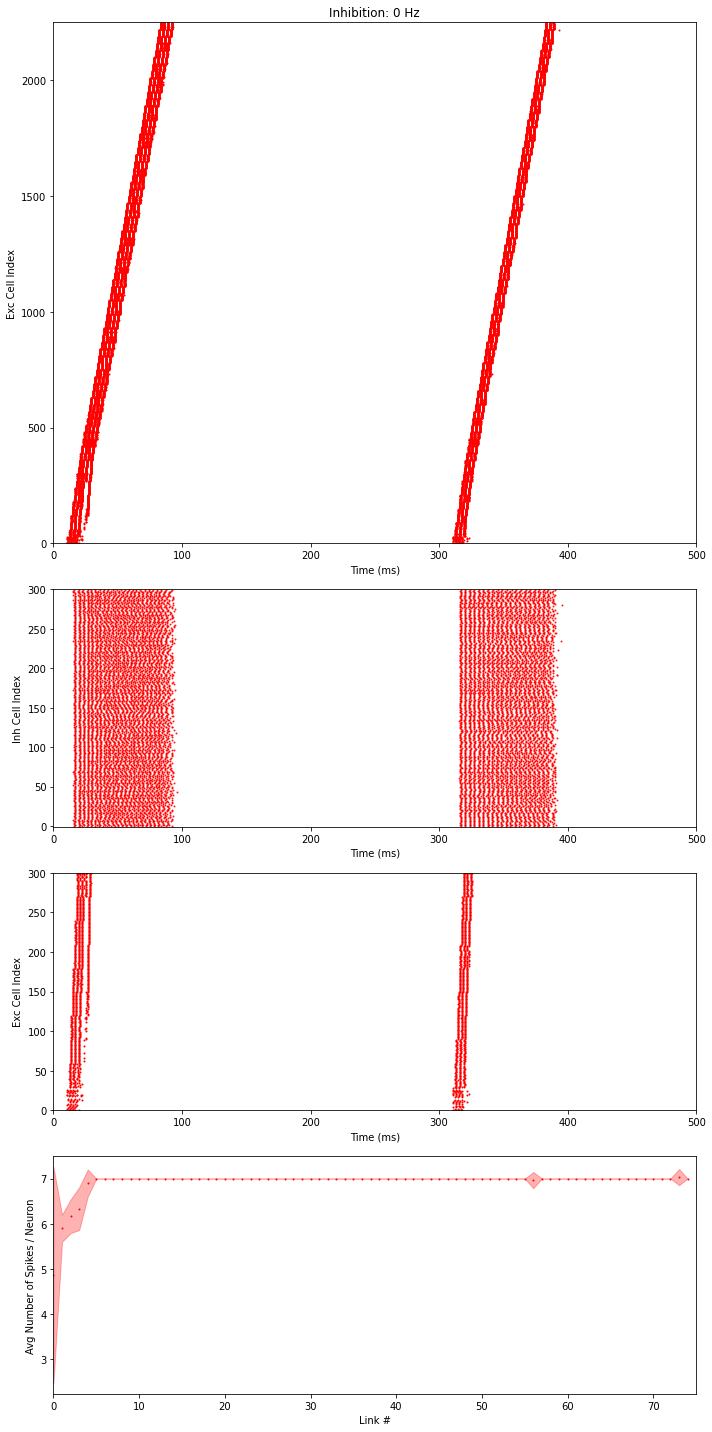

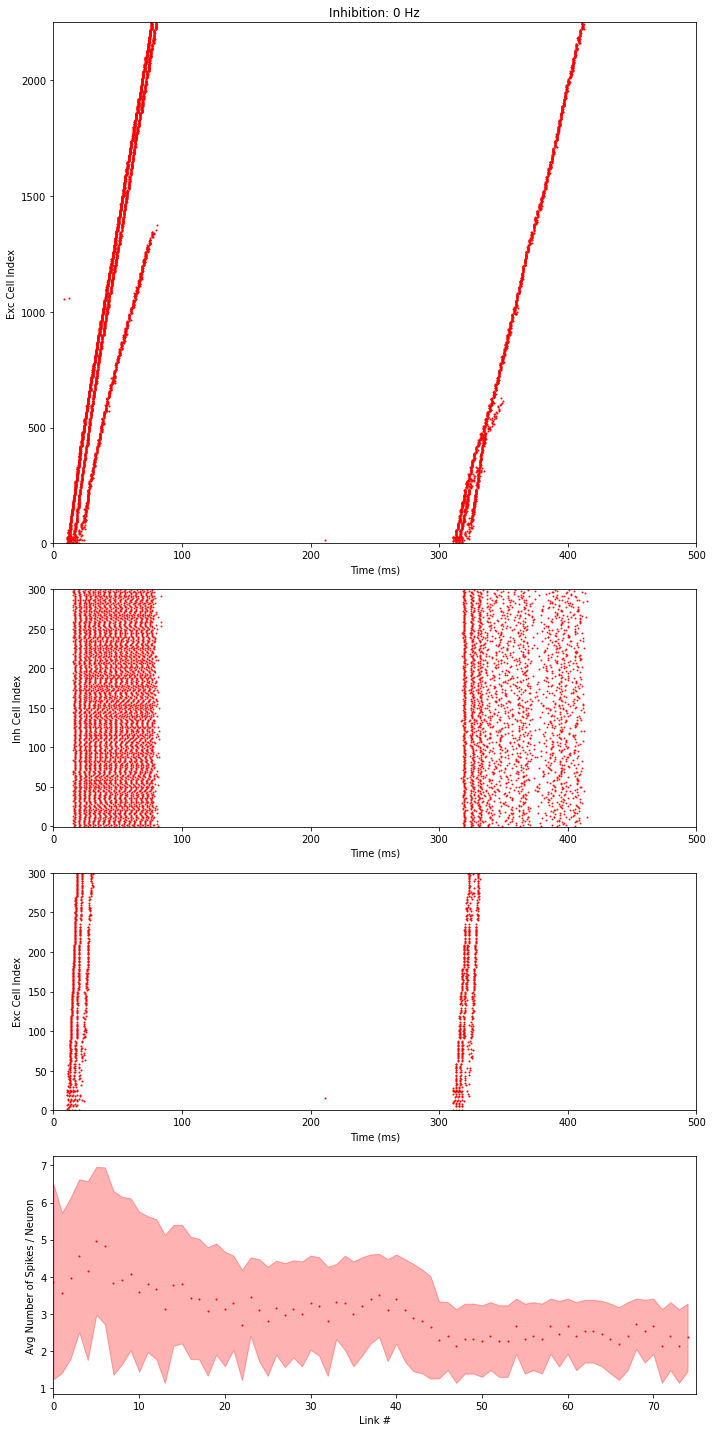

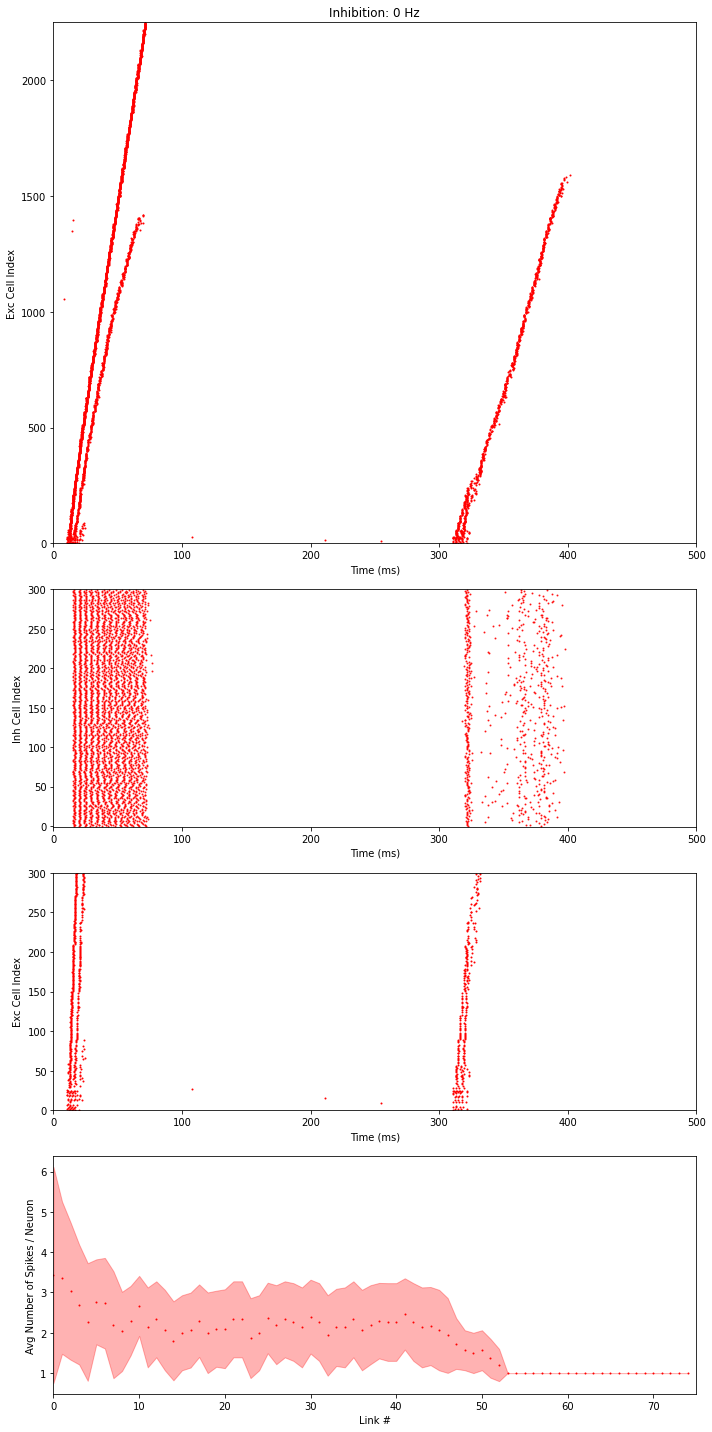

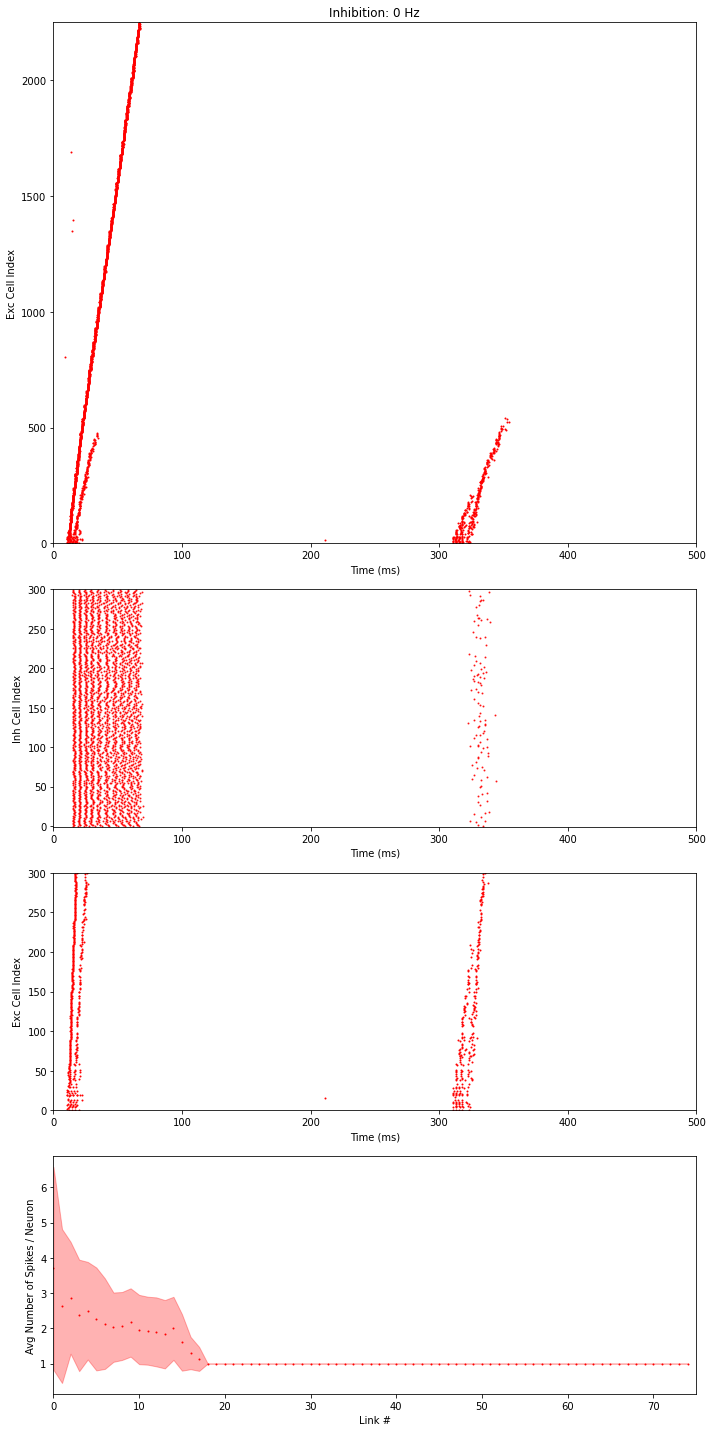

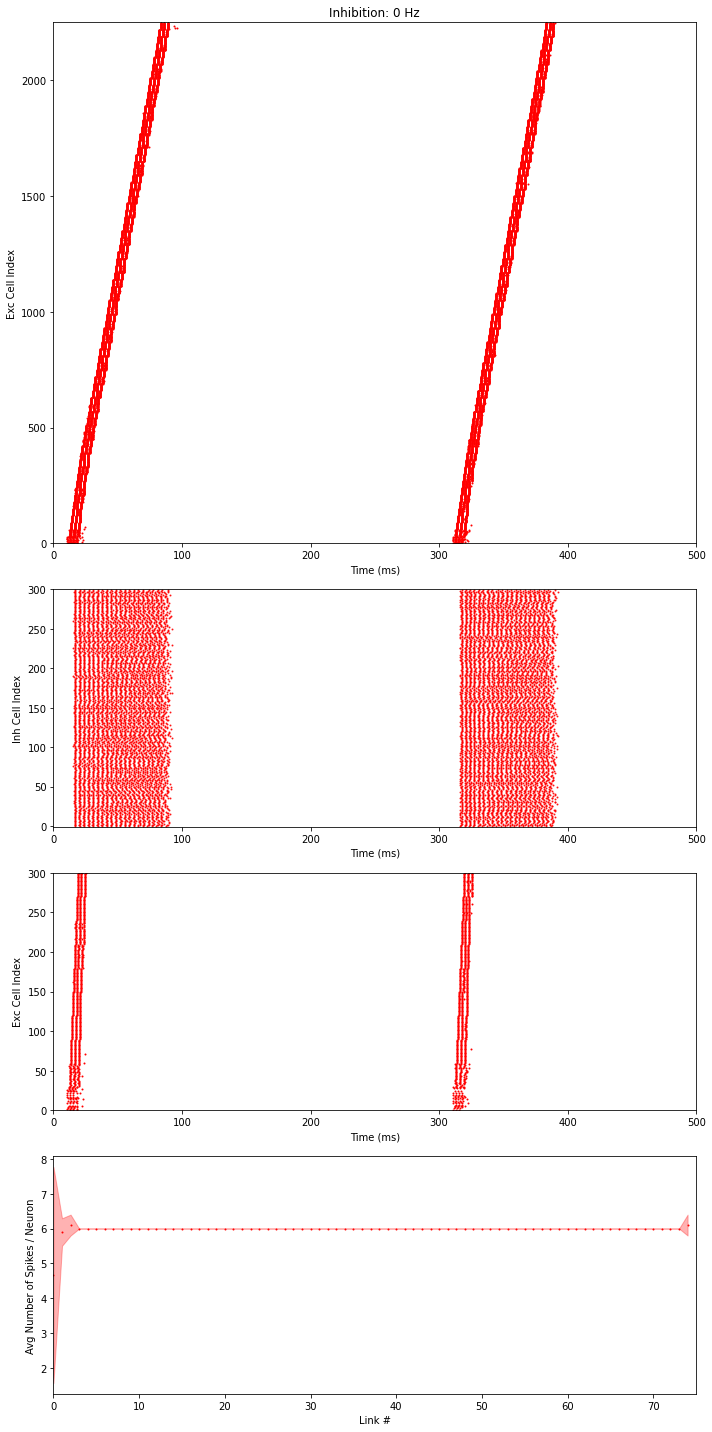

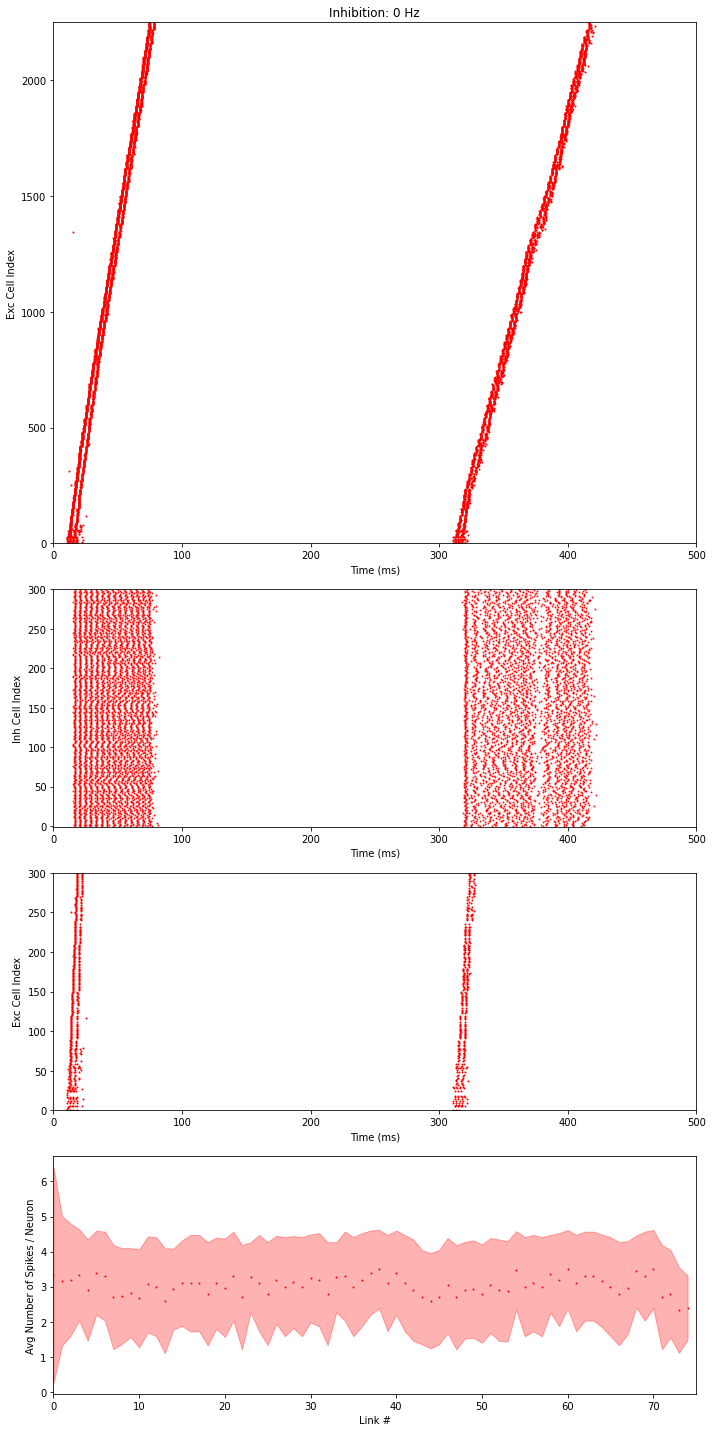

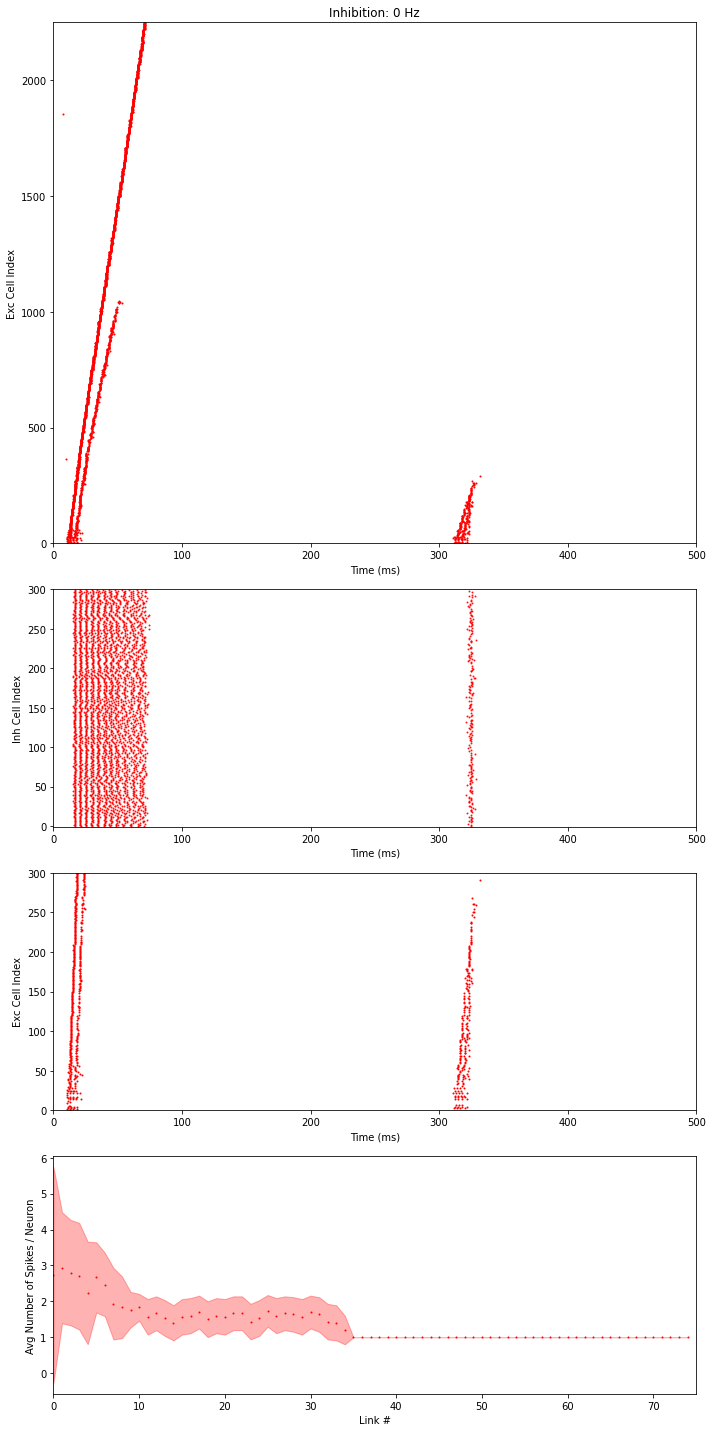

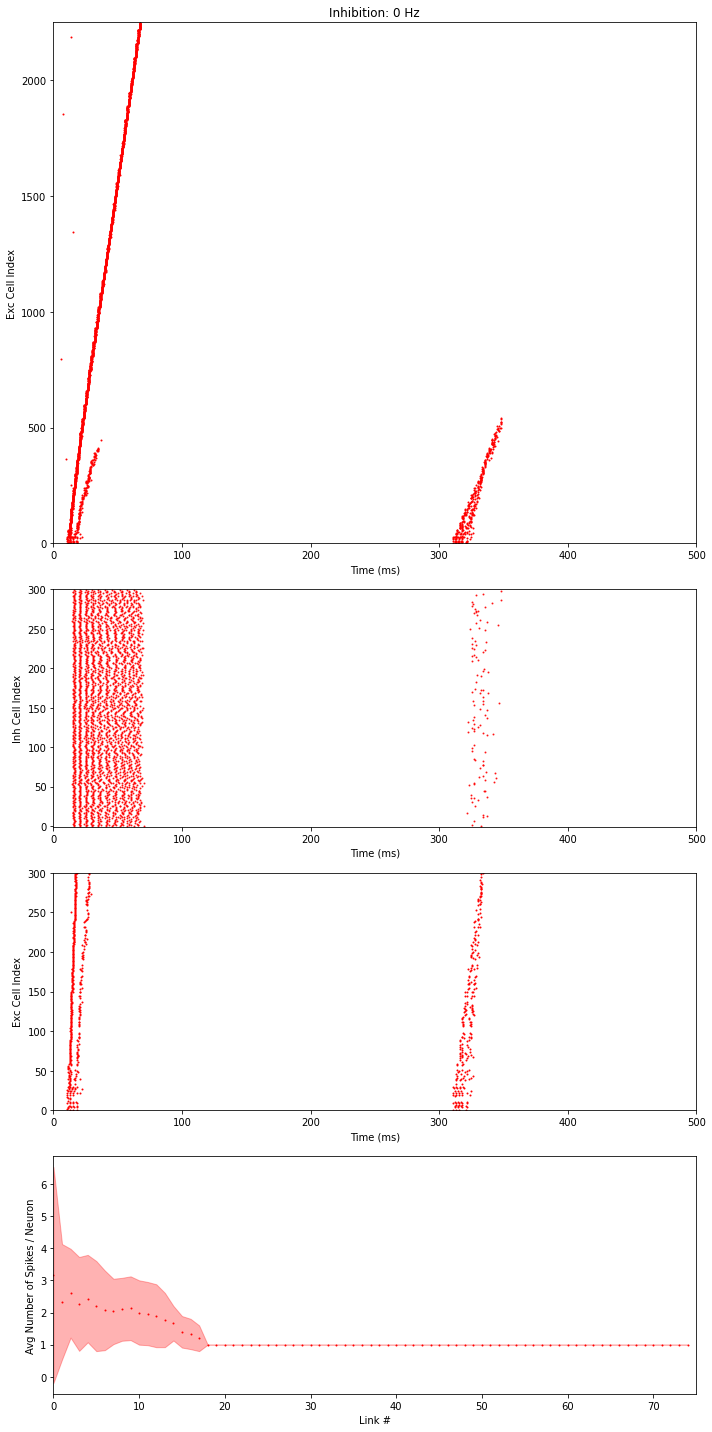

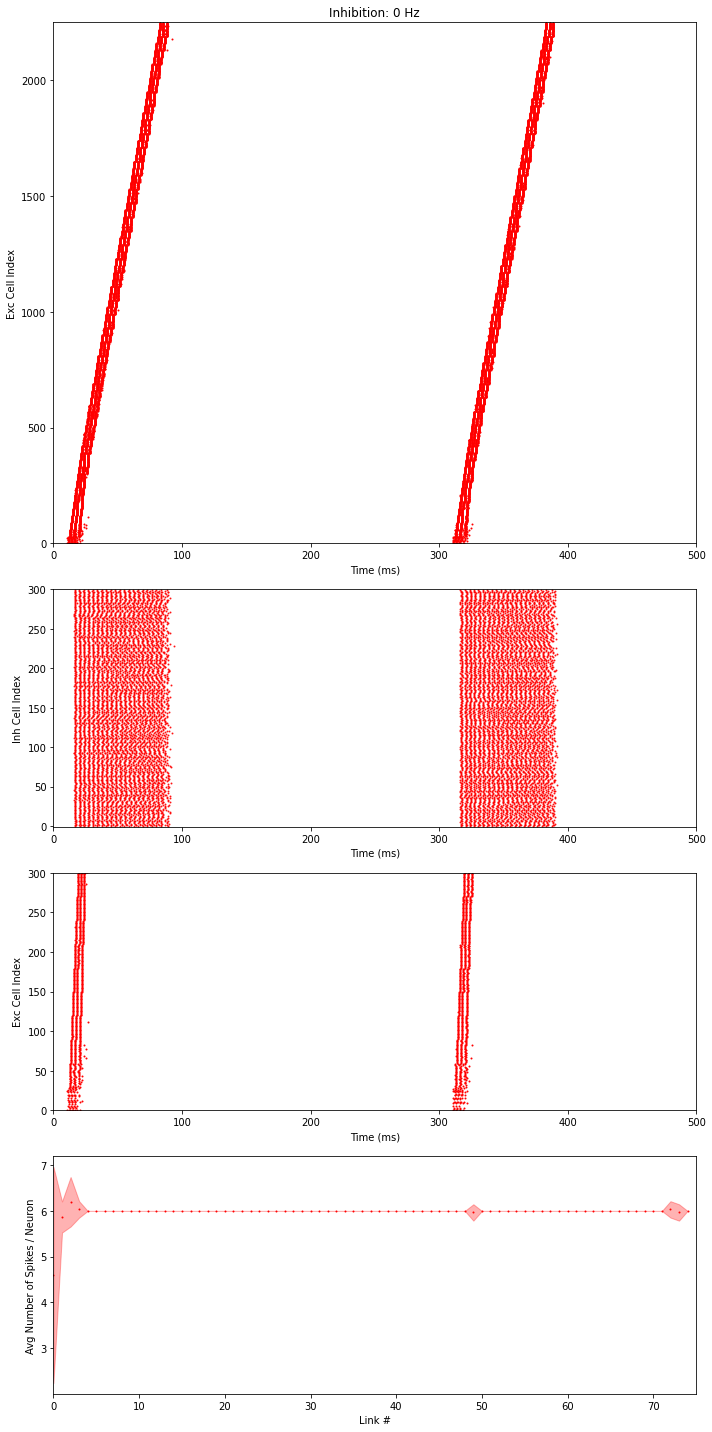

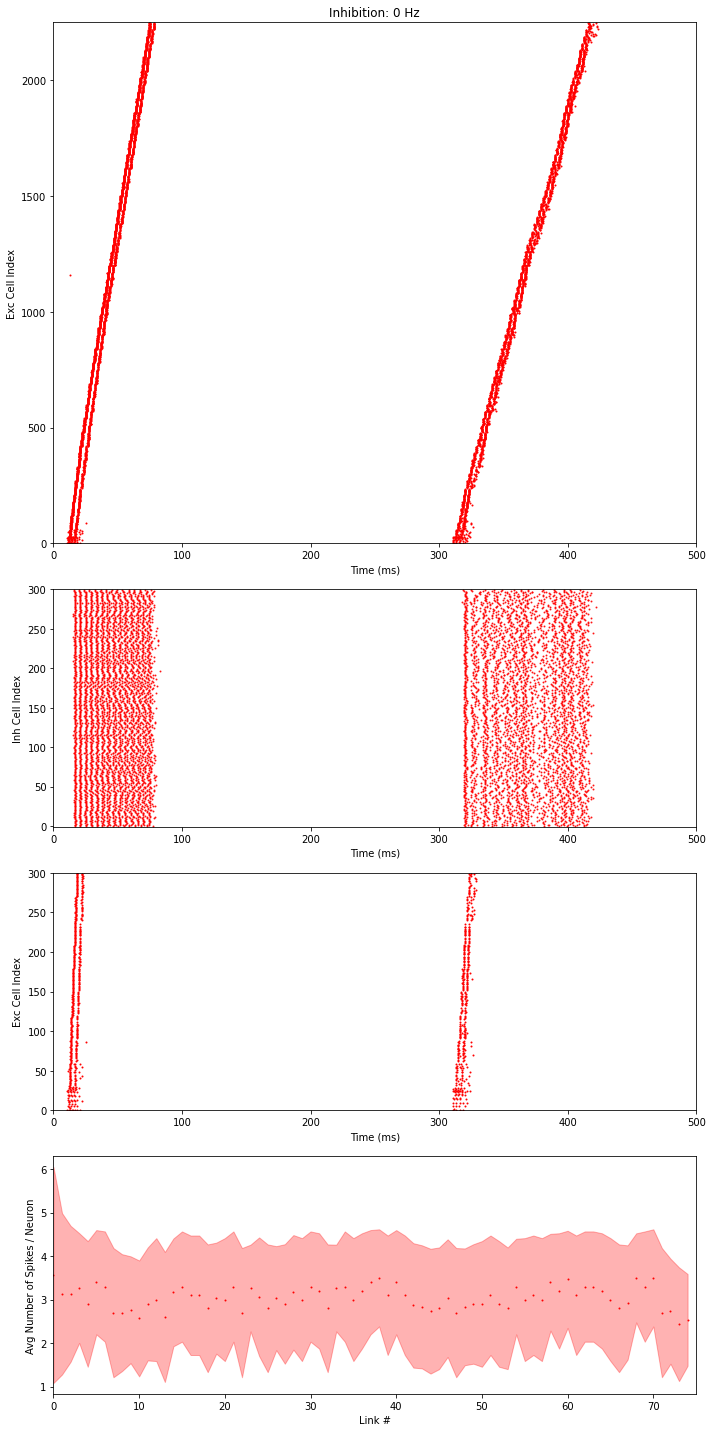

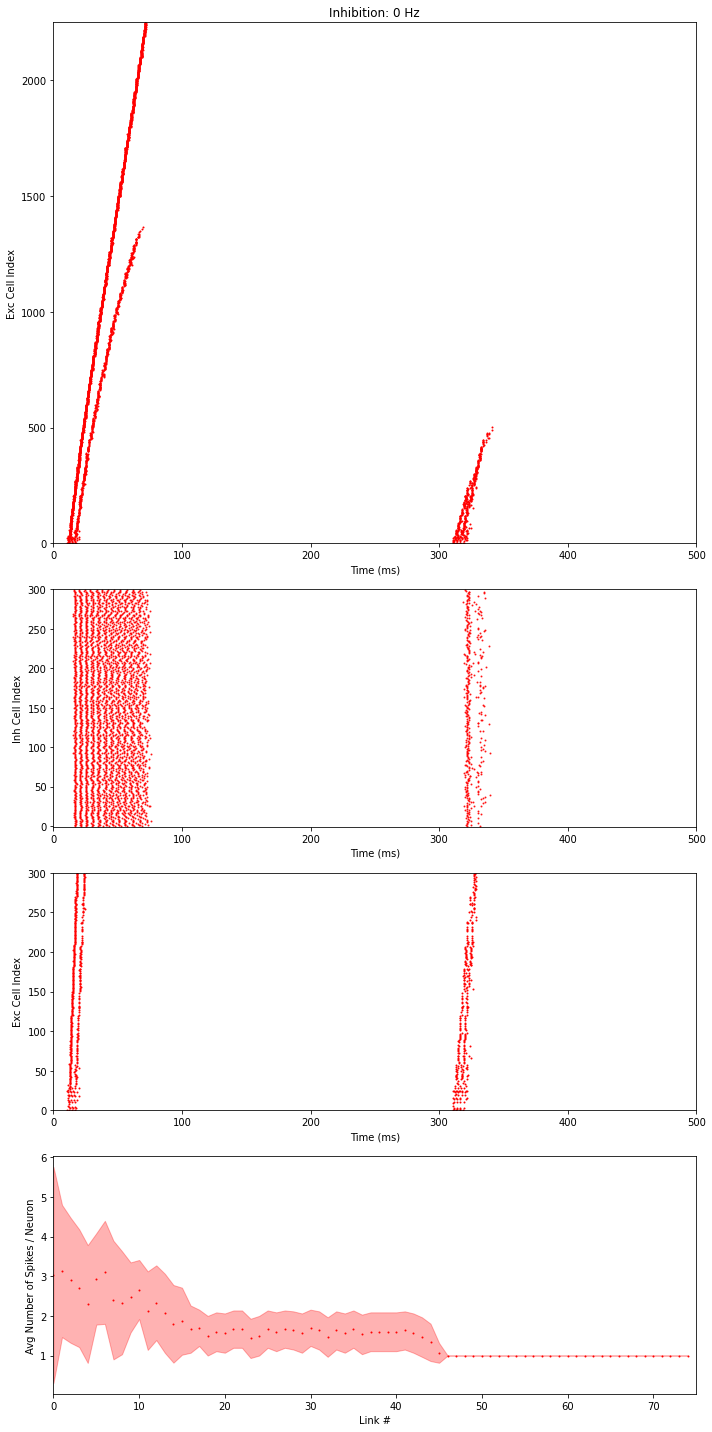

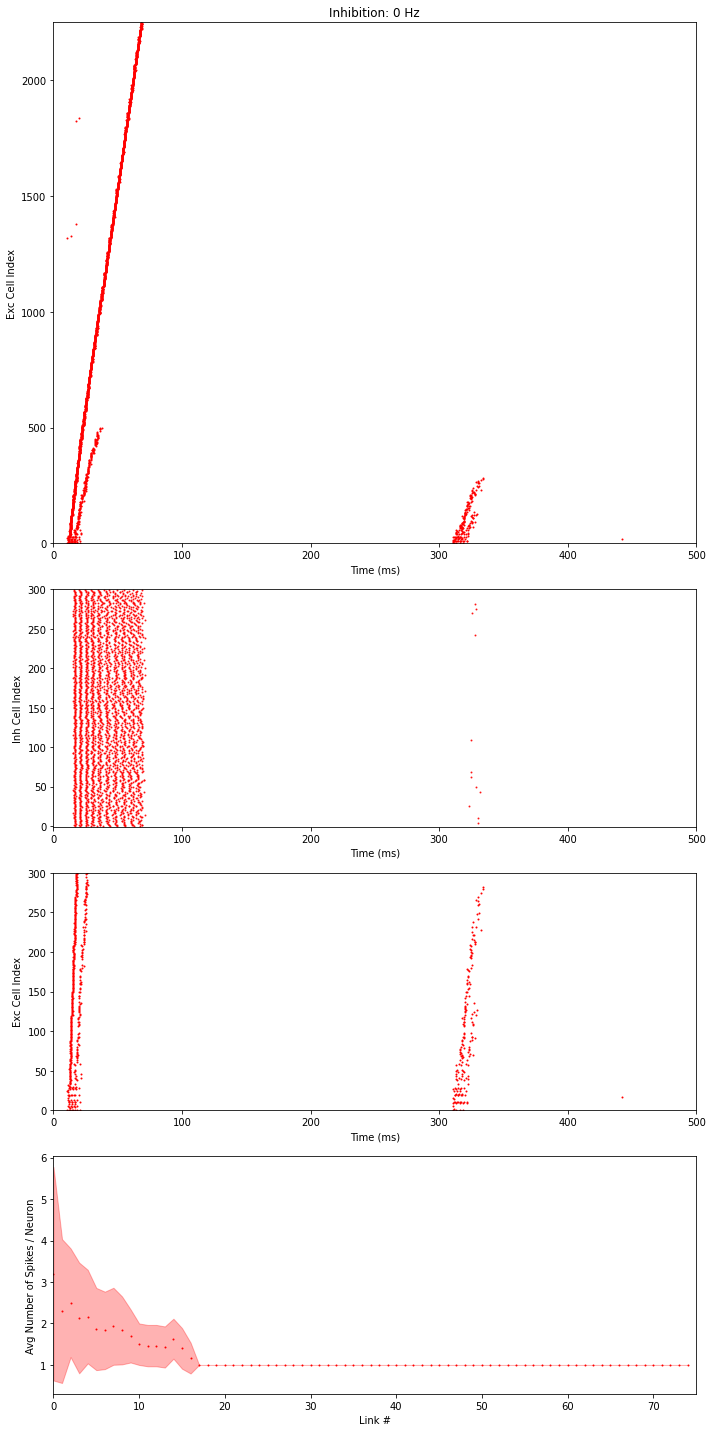

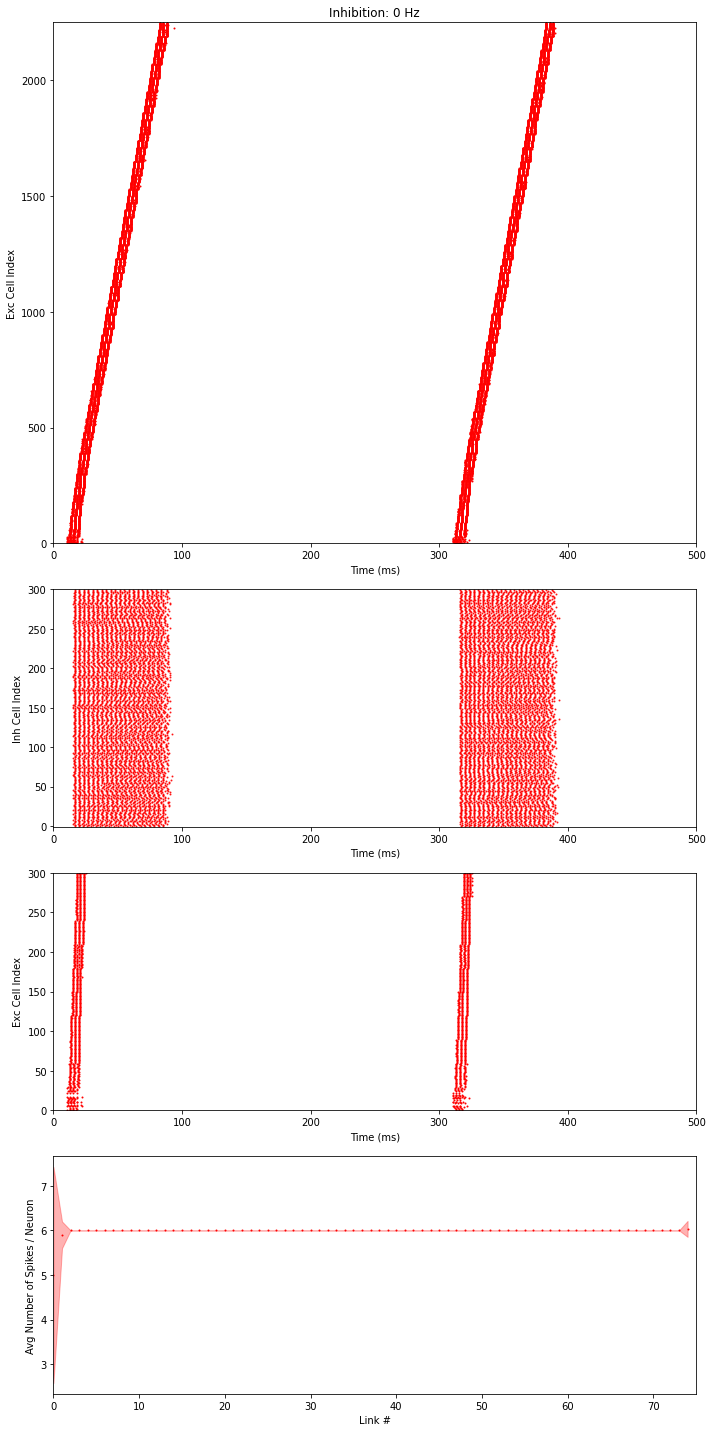

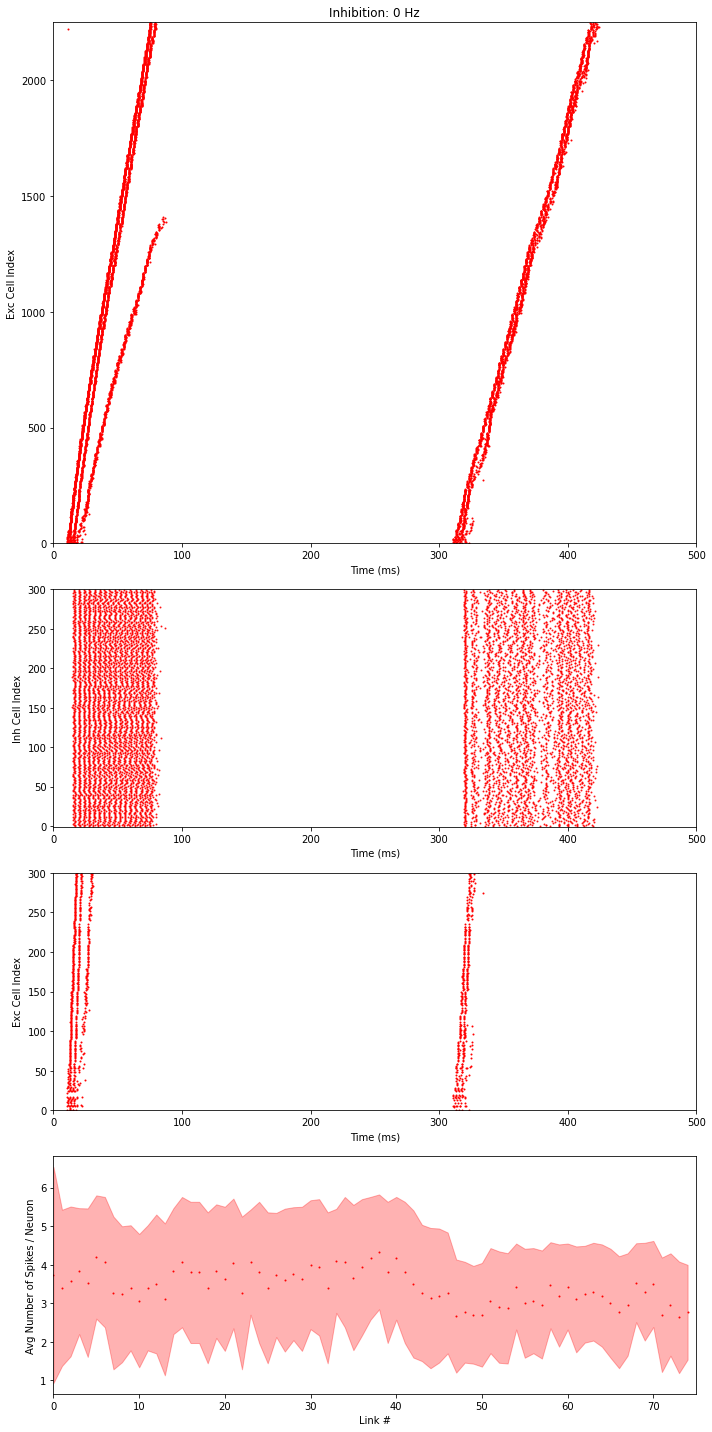

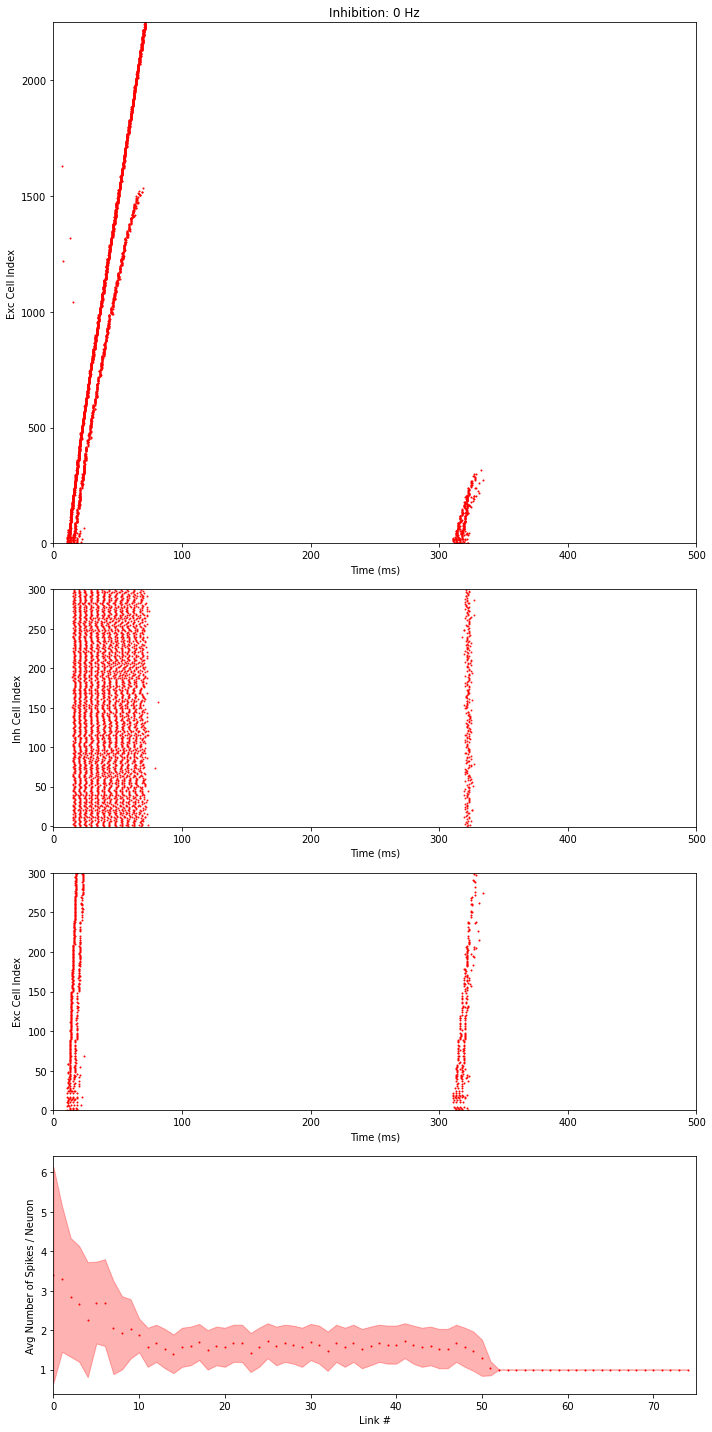

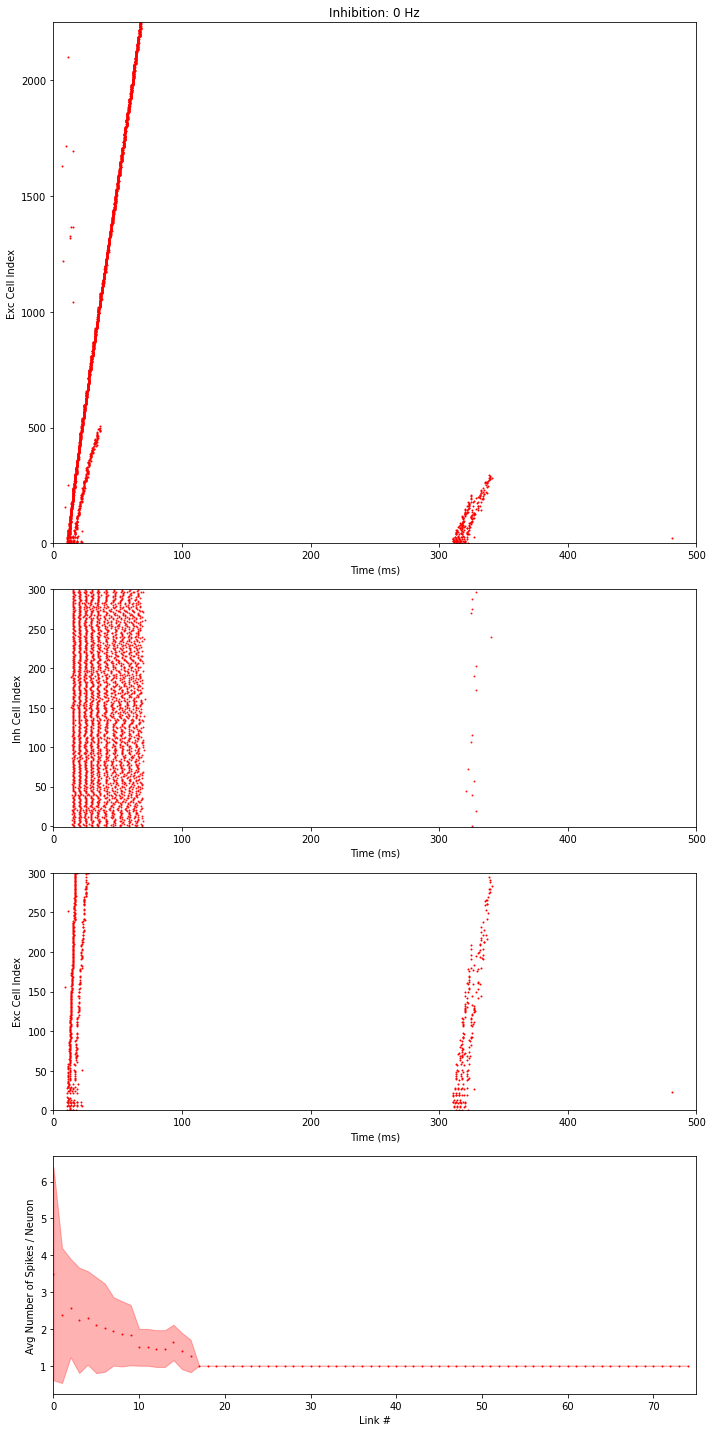

In [59]:
# percentage of excitatory neurons to dropout per trial
dropouts = [{'e': 0, 'i': 0}, {'e': 0.3, 'i': 0}, {'e': 0.4, 'i': 0}, {'e': 0.5, 'i': 0}]
all_res = []

res = quick_plot(m, {
    'e_i':   4 * 0.25e-6,
    'i_e':   0.25e-6,
    'e_e_r': 0,
    'e_e_f': 17e-6,
    'u_i':   0,
}, {
    'e_i':   GaussianPDF(0.75, 0.02),
    'i_e':   GaussianPDF(0.75, 0.02),
    'e_e_r': GaussianPDF(0.7, 0.02),
    'e_e_f': GaussianPDF(0.7, 0.02),
}, dropouts, n_show_only=5, overlay=True, repeats=5, show_connectivity=False)
all_res.append(res)

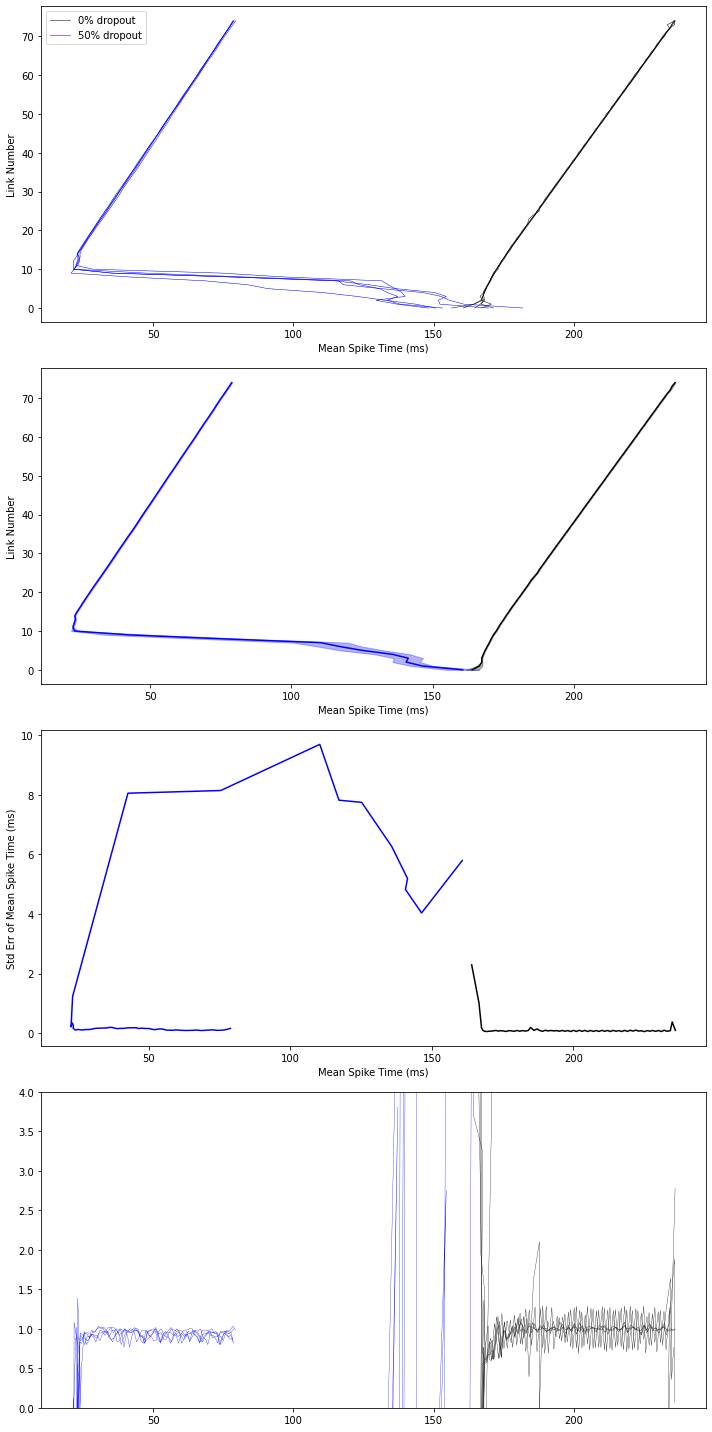

In [120]:
for res in all_res:
    graph_dropout_sim_results(res, labels=['0% dropout', '50% dropout'])

## Pure synfire chain sans noise with varying degres of dropout
- Five realizations of each dropout percentage with 20 different initial excitations with noise in the current removed

In [ ]:
dropouts_2 = [{'e': 0, 'i': 0}, {'e': 0.10, 'i': 0}, {'e': 0.20, 'i': 0}, {'e': 0.30, 'i': 0}]
all_res_2 = []

for i in range(5):
    res = quick_plot(m, {
        'e_i':   4 * 0.25e-6,
        'i_e':   0.25e-6,
        'e_e_r': 0,
        'e_e_f': 17e-6,
        'u_i':   0,
    }, {
        'e_i':   GaussianPDF(0.75, 0.02),
        'i_e':   GaussianPDF(0.75, 0.02),
        'e_e_r': GaussianPDF(0.7, 0.02),
        'e_e_f': GaussianPDF(0.7, 0.02),
    }, dropouts_2, n_show_only=2, overlay=True, repeats=20, show_connectivity=False, add_noise=False)
    all_res_2.append(res)

In [ ]:
for res in all_res_2:
    graph_dropout_sim_results(res, labels=['0% dropout', '10% dropout', '20% dropout', '30% dropout'])

## Pure synfire chain sans noise with varying degrees of dropout
- Repeat of above trials

In [ ]:
dropouts_3 = [{'e': 0, 'i': 0}, {'e': 0.10, 'i': 0}, {'e': 0.20, 'i': 0}, {'e': 0.30, 'i': 0}]
all_res_3 = []

for i in range(5):
    res = quick_plot(m, {
        'e_i':   4 * 0.25e-6,
        'i_e':   0.25e-6,
        'e_e_r': 0,
        'e_e_f': 17e-6,
        'u_i':   0,
    }, {
        'e_i':   GaussianPDF(0.75, 0.02),
        'i_e':   GaussianPDF(0.75, 0.02),
        'e_e_r': GaussianPDF(0.7, 0.02),
        'e_e_f': GaussianPDF(0.7, 0.02),
    }, dropouts_3, n_show_only=20, overlay=True, repeats=20, show_connectivity=False, add_noise=False)
    all_res_3.append(res)

In [ ]:
for res in all_res_3:
    graph_dropout_sim_results(res, labels=['0% dropout', '10% dropout', '20% dropout', '30% dropout'])

## Synfire chain with some recurrent connections with noise and varying degrees of dropout

- 5 unique architectures of each percentage of excitatory neuron dropout
- Each architecture simulated 20 times for unique pairs of excitatory drive and white noise realization
- This chain with intralink recurrent connections

In [ ]:
dropouts_4 = [{'e': 0, 'i': 0}, {'e': 0.10, 'i': 0}, {'e': 0.15, 'i': 0}, {'e': 0.20, 'i': 0}, {'e': 0.30, 'i': 0}]
all_res_4_rec = []

for i in range(5):
    res = quick_plot(m, {
        'e_i':   4 * 0.37e-6,
        'i_e':   0.37e-6,
        'e_e_r': 5.3e-6,
        'e_e_f': 12e-6,
        'u_i':   0,
    }, {
        'e_i':   GaussianPDF(0.75, 0.02),
        'i_e':   GaussianPDF(0.75, 0.02),
        'e_e_r': GaussianPDF(0.7, 0.02),
        'e_e_f': GaussianPDF(0.7, 0.02),
    }, dropouts_4, n_show_only=2, overlay=True, repeats=20, show_connectivity=False)
    all_res_4_rec.append(res)

In [ ]:
for res in all_res_4_rec:
    graph_dropout_sim_results(res, labels=['0% dropout', '10% dropout', '15% dropout', '20% dropout', '30% dropout'])

## Repeat of above experiment with weights modified

In [ ]:
dropouts_5 = [{'e': 0, 'i': 0}, {'e': 0.10, 'i': 0}, {'e': 0.15, 'i': 0}, {'e': 0.20, 'i': 0}, {'e': 0.30, 'i': 0}]
all_res_5_rec = []

for i in range(5):
    res = quick_plot(m, {
        'e_i':   4 * 0.35e-6,
        'i_e':   0.35e-6,
        'e_e_r': 5.3e-6,
        'e_e_f': 10e-6,
        'u_i':   0,
    }, {
        'e_i':   GaussianPDF(0.75, 0.02),
        'i_e':   GaussianPDF(0.75, 0.02),
        'e_e_r': GaussianPDF(0.7, 0.02),
        'e_e_f': GaussianPDF(0.7, 0.02),
    }, dropouts_5, n_show_only=1, overlay=True, repeats=20, show_connectivity=False)
    all_res_5_rec.append(res)

In [ ]:
for res in all_res_5_rec:
    graph_dropout_sim_results(res, labels=['0% dropout', '10% dropout', '15% dropout', '20% dropout', '30% dropout'])

## Synfire chain with some recurrent connections WITHOUT noise and varying degrees of dropout

- 5 unique architectures of each percentage of excitatory neuron dropout
- Each architecture simulated 20 times for distinct excitatory drives
- This chain with intralink recurrent connections

In [ ]:
dropouts_6 = [{'e': 0, 'i': 0}, {'e': 0.10, 'i': 0}, {'e': 0.15, 'i': 0}, {'e': 0.20, 'i': 0}, {'e': 0.30, 'i': 0}]
all_res_6_rec = []

for i in range(5):
    res = quick_plot(m, {
        'e_i':   4 * 0.35e-6,
        'i_e':   0.35e-6,
        'e_e_r': 5.3e-6,
        'e_e_f': 10e-6,
        'u_i':   0,
    }, {
        'e_i':   GaussianPDF(0.75, 0.02),
        'i_e':   GaussianPDF(0.75, 0.02),
        'e_e_r': GaussianPDF(0.7, 0.02),
        'e_e_f': GaussianPDF(0.7, 0.02),
    }, dropouts_6, n_show_only=2, overlay=True, repeats=20, show_connectivity=False, add_noise=False)
    all_res_6_rec.append(res)

In [ ]:
for res in all_res_6_rec:
    graph_dropout_sim_results(res, labels=['0% dropout', '10% dropout', '15% dropout', '20% dropout', '30% dropout'])